<a href="https://www.kaggle.com/kalilurrahman/ubiquant-market-forecast-and-eda?scriptVersionId=89683064" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ubiquant-market-prediction/example_sample_submission.csv
/kaggle/input/ubiquant-market-prediction/example_test.csv
/kaggle/input/ubiquant-market-prediction/train.csv
/kaggle/input/ubiquant-market-prediction/ubiquant/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/ubiquant-market-prediction/ubiquant/__init__.py
/kaggle/input/ubiquant-parquet/example_sample_submission.parquet
/kaggle/input/ubiquant-parquet/example_test.parquet
/kaggle/input/ubiquant-parquet/train.parquet
/kaggle/input/ubiquant-parquet/train_low_mem.parquet
/kaggle/input/ubiquant-parquet/investment_ids/3136.parquet
/kaggle/input/ubiquant-parquet/investment_ids/858.parquet
/kaggle/input/ubiquant-parquet/investment_ids/861.parquet
/kaggle/input/ubiquant-parquet/investment_ids/500.parquet
/kaggle/input/ubiquant-parquet/investment_ids/2197.parquet
/kaggle/input/ubiquant-parquet/investment_ids/2825.parquet
/kaggle/input/ubiquant-parquet/investment_ids/139.parquet
/kaggle/input/ubiquant-parquet/investmen

In [2]:
%matplotlib inline
from IPython.core.display import display, HTML, Javascript

html_contents ="""
<!DOCTYPE html>
<html lang="en">
    <head>
        <link rel="stylesheet" href="https://www.w3schools.com/w3css/4/w3.css">
        <link rel="stylesheet" href="https://fonts.googleapis.com/css?family=Raleway">
        <link rel="stylesheet" href="https://fonts.googleapis.com/css?family=Oswald">
        <link rel="stylesheet" href="https://fonts.googleapis.com/css?family=Open Sans">
        <link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/4.7.0/css/font-awesome.min.css">
        <style>
        .title-section{
            font-family: "Roboto", Verdana, sans-serif;
            font-weight: bold;
            color: "#8B008B";
            letter-spacing: 8px;
        }
        hr { border: 1px solid #E58F65 !important;
             color: #E58F65 !important;
             background: #E58F65 !important;
           }
        body {
            font-family: "Open Sans", sans-serif;
            }        
        </style>
    </head>    
</html>
"""

HTML(html_contents)

#  <span class="title-section w3-xxlarge" style="color:#FF0080"> Ubiquant Market Prediction - Brief Intro </span>

### <span class="title-section w3-large" style="color:magenta">To be updated.</span>



#  <span class="title-section w3-xxlarge" style="color:#FF0080"> 1. Import Libraries</span>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import dask.dataframe as dd
import datatable as dt

import gc  

import seaborn as sns
from scipy.stats import pearsonr
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

# For reading stock data from yahoo
from pandas_datareader.data import DataReader
   
# For time stamps
from datetime import datetime
from math import sqrt
from math import sqrt


#ignore the warnings
import warnings
warnings.filterwarnings('ignore')

#  <span class="title-section w3-xxlarge" style="color:#FF0080"> 2. Load Dataset</span>

In [4]:
%%time
train = pd.read_parquet('../input/ubiquant-parquet/train_low_mem.parquet')




CPU times: user 12 s, sys: 8.49 s, total: 20.4 s
Wall time: 40.6 s


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3141410 entries, 0 to 3141409
Columns: 304 entries, row_id to f_299
dtypes: float32(301), object(1), uint16(2)
memory usage: 3.6+ GB


In [6]:
train.dtypes




row_id            object
time_id           uint16
investment_id     uint16
target           float32
f_0              float32
                  ...   
f_295            float32
f_296            float32
f_297            float32
f_298            float32
f_299            float32
Length: 304, dtype: object

In [7]:


train.head(10)

row_id  time_id  investment_id    target       f_0       f_1       f_2  \
0    0_1        0              1 -0.300875  0.932573  0.113691 -0.402206   
1    0_2        0              2 -0.231040  0.810802 -0.514115  0.742368   
2    0_6        0              6  0.568807  0.393974  0.615937  0.567806   
3    0_7        0              7 -1.064780 -2.343535 -0.011870  1.874606   
4    0_8        0              8 -0.531940  0.842057 -0.262993  2.330030   
5    0_9        0              9  1.505904  0.608855  1.369305 -0.761515   
6   0_10        0             10 -0.260731 -1.863797  0.113691  1.573864   
7   0_12        0             12 -0.469207  0.408954 -0.765238  0.261430   
8   0_13        0             13  0.094525  0.861187  2.373796 -1.148977   
9   0_14        0             14 -0.251120 -2.476555  0.239253  2.222353   

        f_3       f_4       f_5  ...     f_290     f_291     f_292     f_293  \
0  0.378386 -0.203938 -0.413469  ...  0.366028 -1.095620  0.200075  0.819155   
1 -0.616673 -0.194255  1.771210  ... -0.154193  0.912726 -0.734579  0.819155   
2 -0.607963  0.068883 -1.083155  ... -0.138020  0.912726 -0.551904 -1.220772   
3 -0.606346 -0.586827 -0.815737  ...  0.382201  0.912726 -0.266359 -1.220772   
4 -0.583422 -0.618392 -0.742814  ... -0.170365  0.912726 -0.741355 -1.220772   
5  0.865860 -0.359269 -1.835762  ...  0.333684 -1.095620 -0.335999  0.819155   
6 -0.598433 -0.569936  0.398784  ...  0.821560  0.912726  0.476309 -1.220772   
7 -0.591895 -0.037260  0.668721  ...  0.821560 -1.095620 -0.864354 -1.220772   
8  0.752205 -0.050502 -2.249047  ... -0.658241  0.912726  0.718282  0.819155   
9 -0.582276 -0.618236  0.386263  ...  0.821560 -1.095620 -0.615709 -1.220772   

      f_294     f_295     f_296     f_297     f_298     f_299  
0  0.941183 -0.086764 -1.087009 -1.044826 -0.287605  0.321566  
1  0.941183 -0.387617 -1.087009 -0.929529 -0.974060 -0.343624  
2 -1.060166 -0.219097 -1.087009 -0.612428 -0.113944  0.243608  
3  0.941183 -0.609113  0.104928 -0.783423  1.151730 -0.773309  
4  0.941183 -0.588445  0.104928  0.753279  1.345611 -0.737624  
5 -1.060166 -0.343812 -1.087009  0.077862  0.142943 -0.055550  
6  0.941183 -0.434315  1.296864  0.171329  1.051288 -0.745335  
7 -1.060166 -0.300218  1.296864 -0.779556  0.274961 -0.182520  
8  0.941183  4.198117  1.296864  1.854434  0.000000 -0.688340  
9 -1.060166 -0.647769  0.104928 -0.849789  0.805876 -0.820165  

[10 rows x 304 columns]

In [8]:
train['target'].value_counts()

 0.000000    1736
 0.003361      64
 0.000342      40
-0.004886      30
-0.011058      28
             ... 
-0.865023       1
 0.191282       1
-0.797270       1
 0.047269       1
 1.212112       1
Name: target, Length: 3066513, dtype: int64

In [9]:
np.random.seed(2110)
#train = train.sample(10000)
#test = test.sample(10000)

<AxesSubplot:>

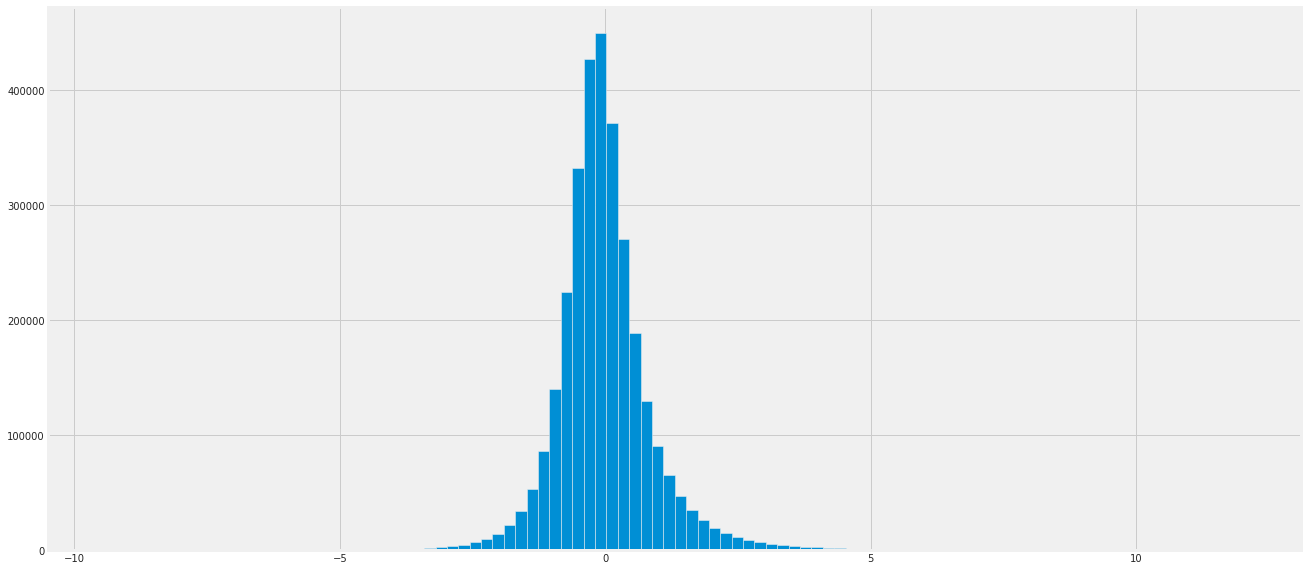

In [10]:
train['target'].hist(bins = 100, figsize = (20,10))

In [11]:
train['investment_id'].nunique()

3579

In [12]:

'''                                                          
                                                            
#  Categorical Data
a = 529  # number of rows
b = 6  # number of columns
c = 1  # initialize plot counter

fig = plt.figure(figsize=(14,10))

for f in train['investment_id'].unique():
    plt.subplot(a, b, c)
    train[train['investment_id'] == f]['target'].hist(bins = 100, alpha = 0.2, figsize = (20,10))
    #plt.title('{}, subplot: {}{}{}'.format(i, a, b, c))
    plt.xlabel(f)
    c = c + 1

plt.show()
'''

"                                                          \n                                                            \n#  Categorical Data\na = 529  # number of rows\nb = 6  # number of columns\nc = 1  # initialize plot counter\n\nfig = plt.figure(figsize=(14,10))\n\nfor f in train['investment_id'].unique():\n    plt.subplot(a, b, c)\n    train[train['investment_id'] == f]['target'].hist(bins = 100, alpha = 0.2, figsize = (20,10))\n    #plt.title('{}, subplot: {}{}{}'.format(i, a, b, c))\n    plt.xlabel(f)\n    c = c + 1\n\nplt.show()\n"

<AxesSubplot:xlabel='investment_id', ylabel='investment_id'>

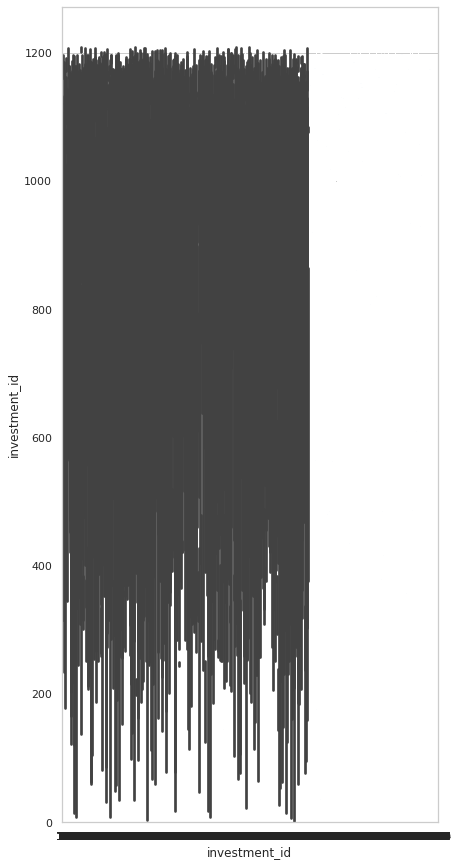

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 15))
# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(y=train['investment_id'].value_counts().sort_values(ascending=False), x="investment_id", data=train,
            label="Total", color="b")

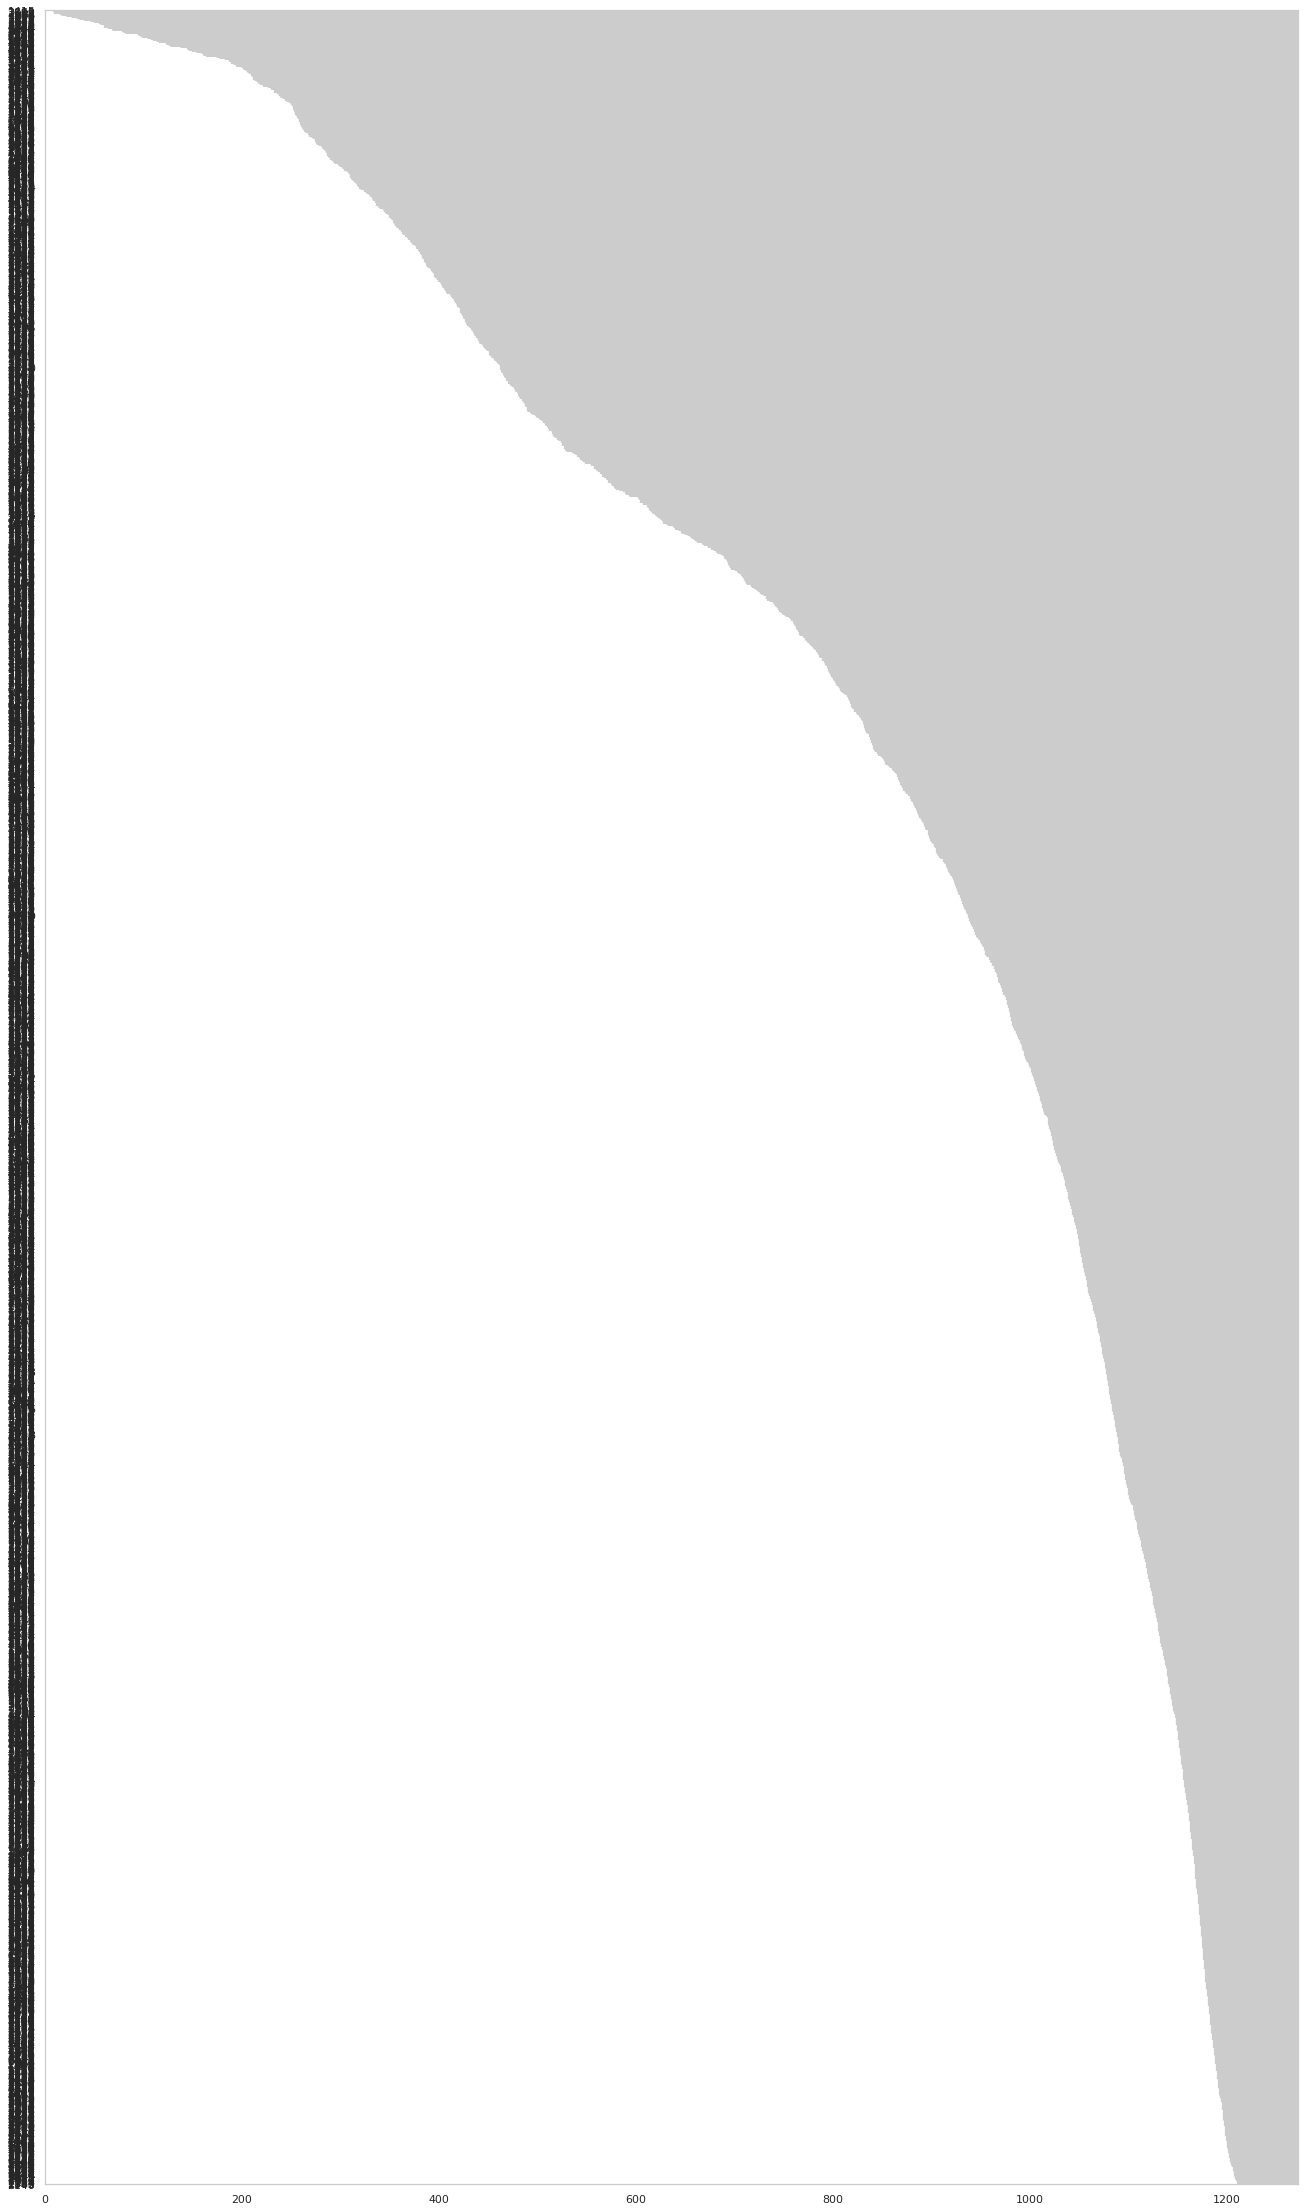

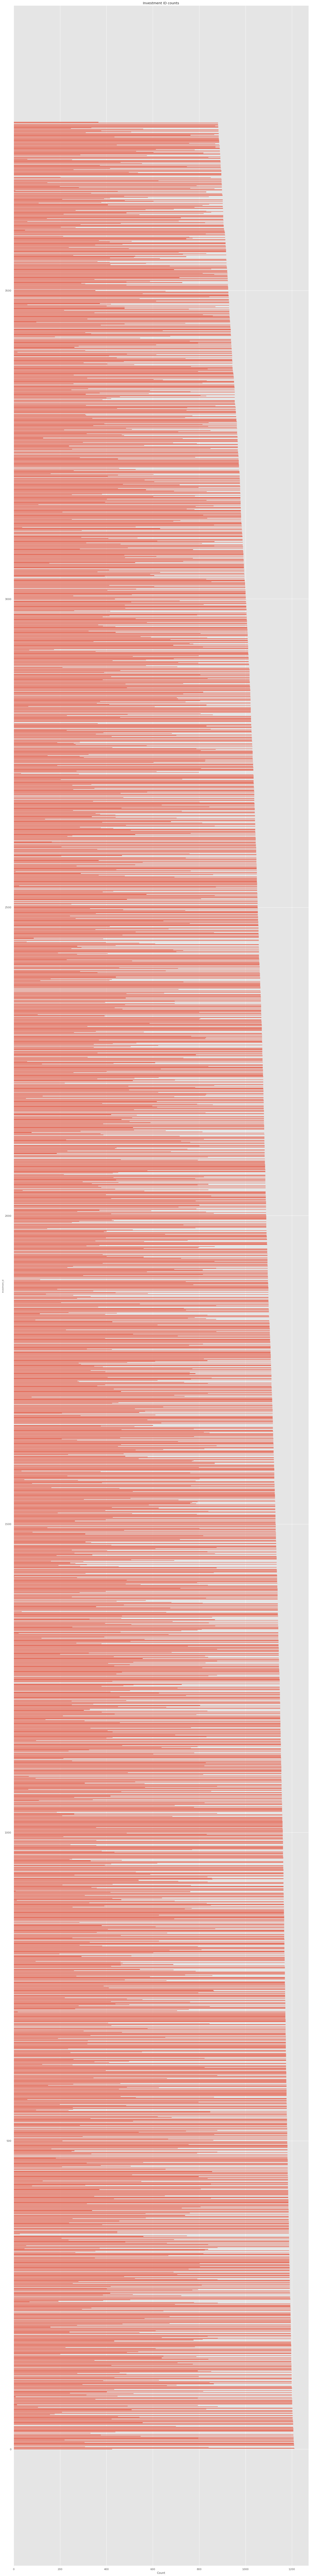

In [14]:
train['investment_id'].value_counts().plot(kind = 'barh',figsize = (20,40))

plt.figure(figsize = (20,200))

plt.style.use('ggplot')

inv = train['investment_id'].unique()
values = train['investment_id'].value_counts()

plt.barh(inv, values)
plt.title('Investment ID counts')
plt.ylabel('investment_id', size = 8)
plt.xlabel('Count')
plt.show()

In [15]:
correlation = train.corr()

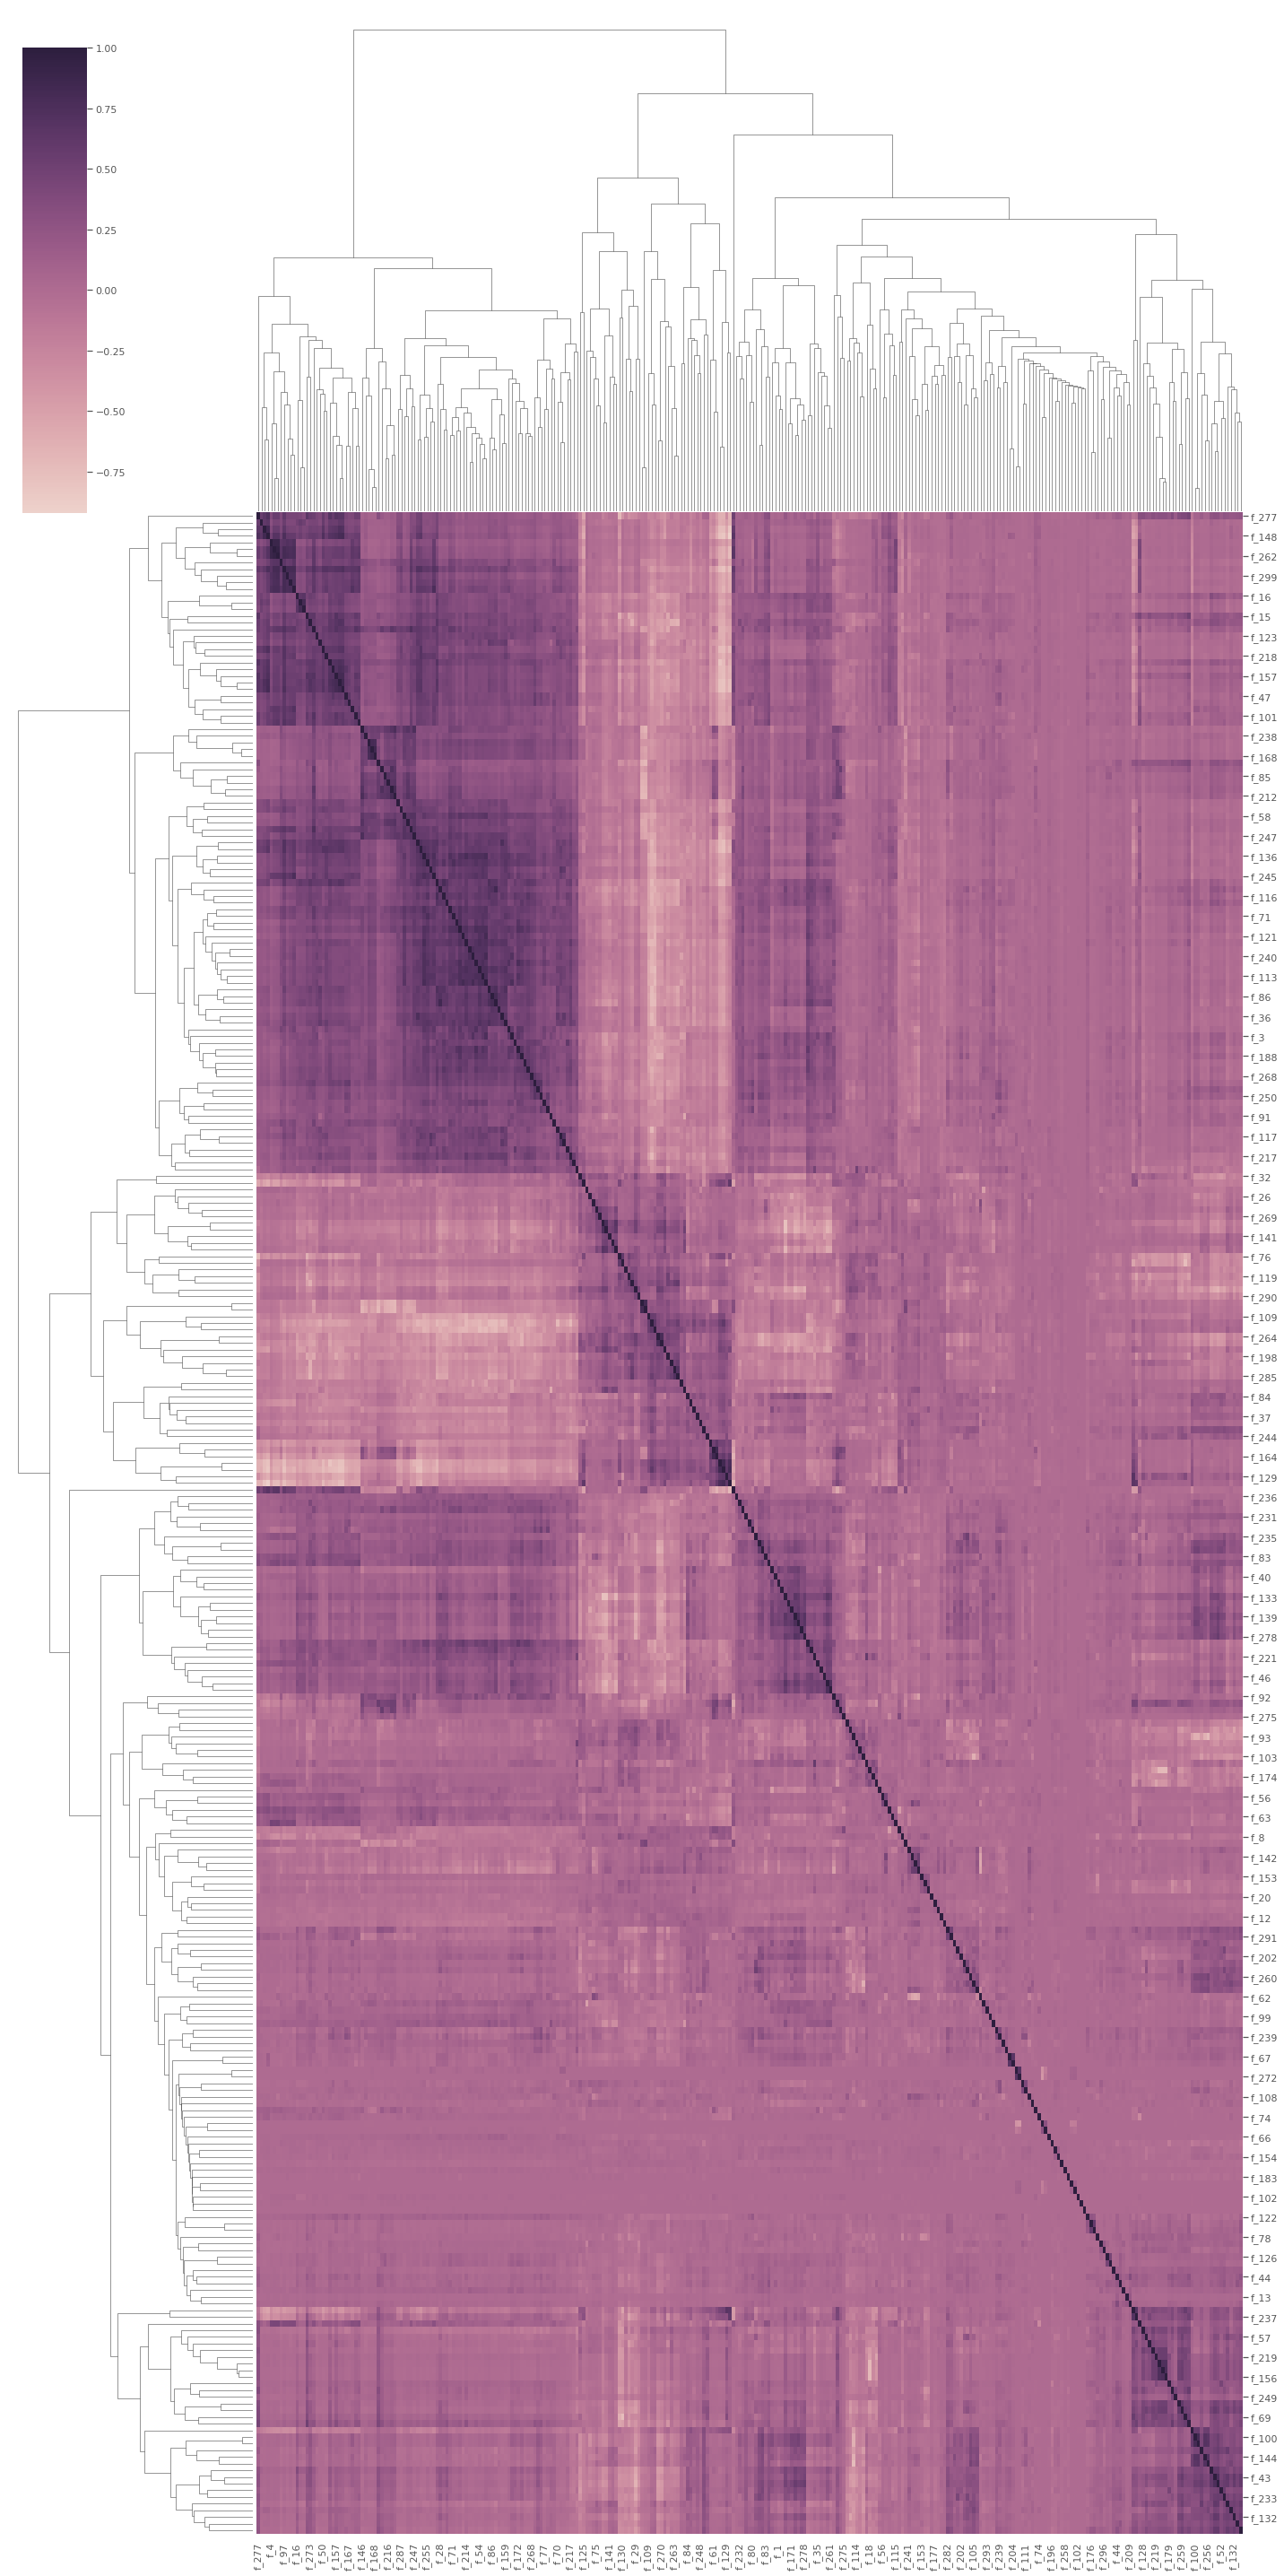

In [16]:
import seaborn as sns
sns.clustermap(correlation, figsize=(20, 40),cmap = sns.cubehelix_palette(as_cmap=True))

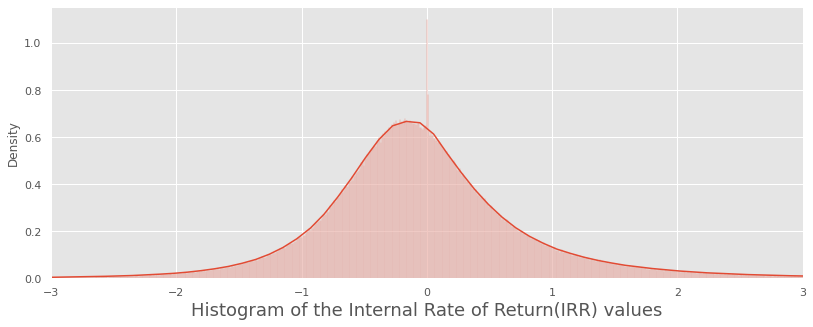

692510

In [17]:
plt.figure(figsize = (12,5))
ax = sns.distplot(train['target'], bins=5000)
plt.xlim(-3,3)
plt.xlabel("Histogram of the Internal Rate of Return(IRR) values", size=18)
plt.show();
gc.collect()

##  <span class="title-section w3-xlarge" style="color:#FF0080"> Data features</span>

####  <span class="title-section w3-large" style="color:#FF0080"> Features</span>




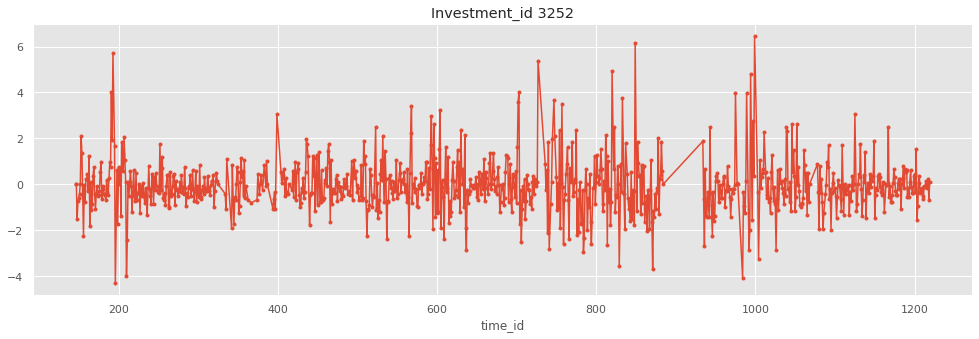

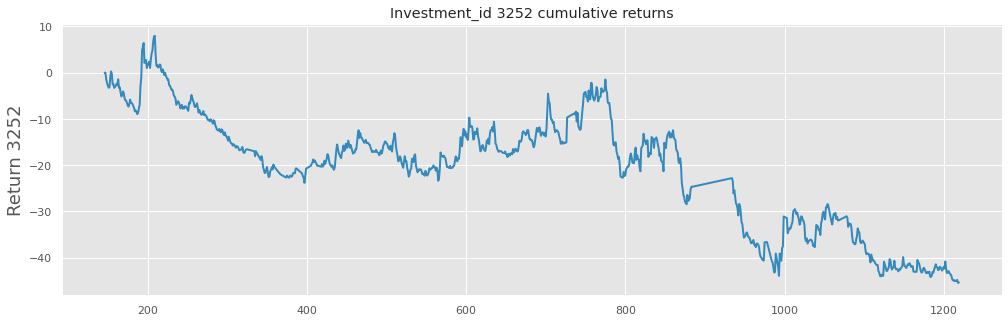

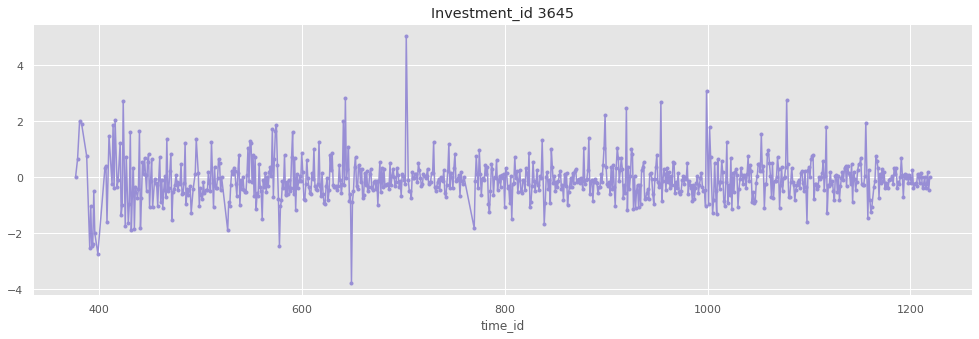

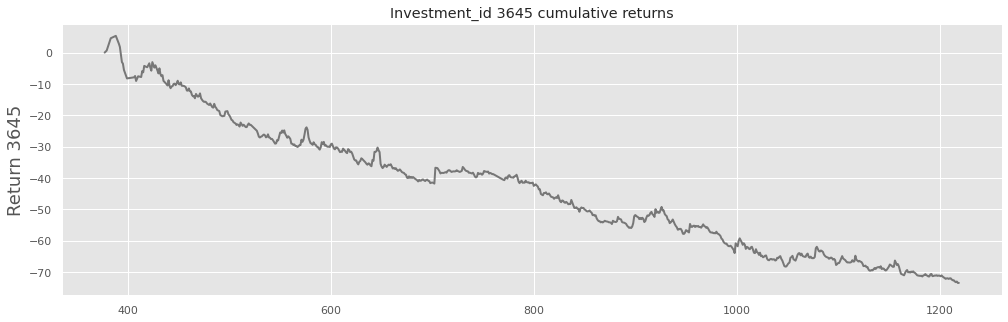

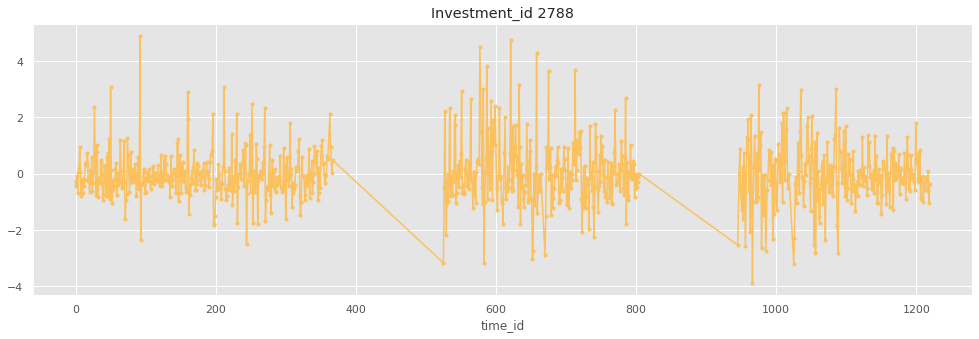

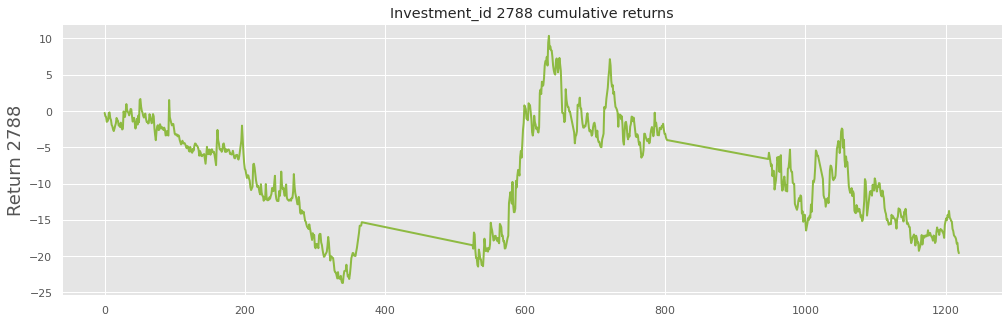

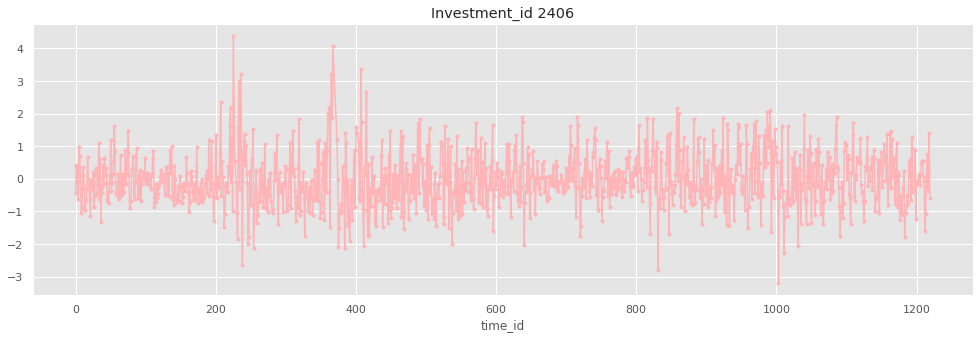

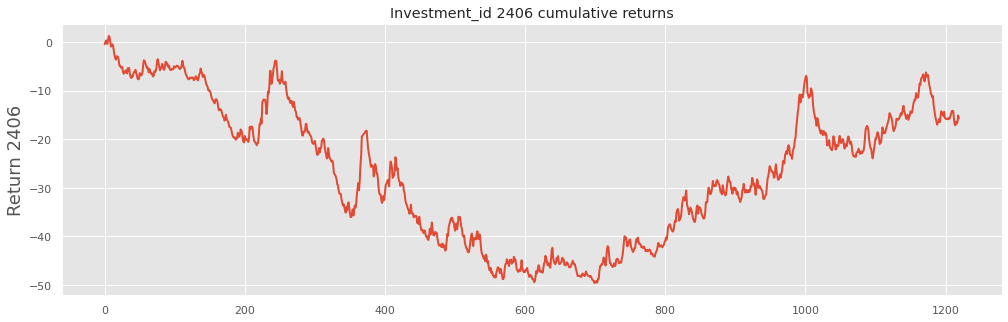

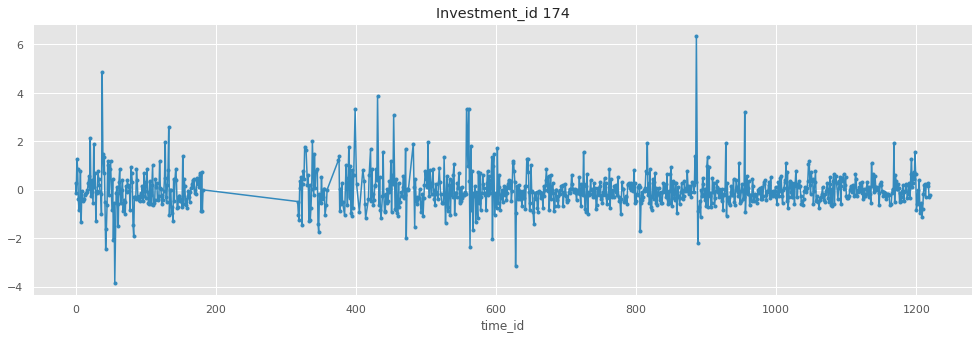

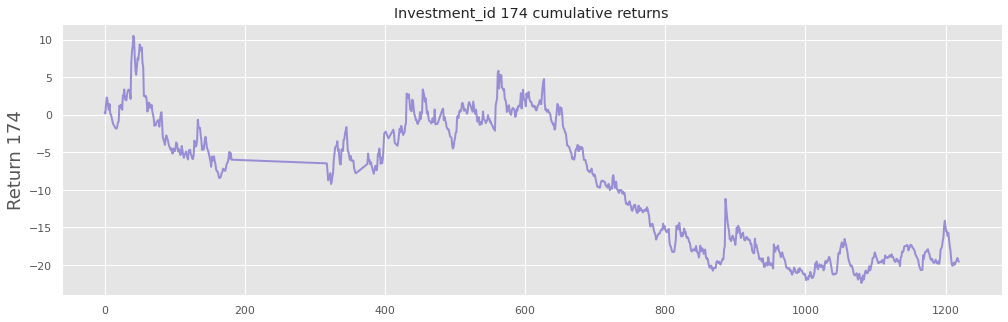

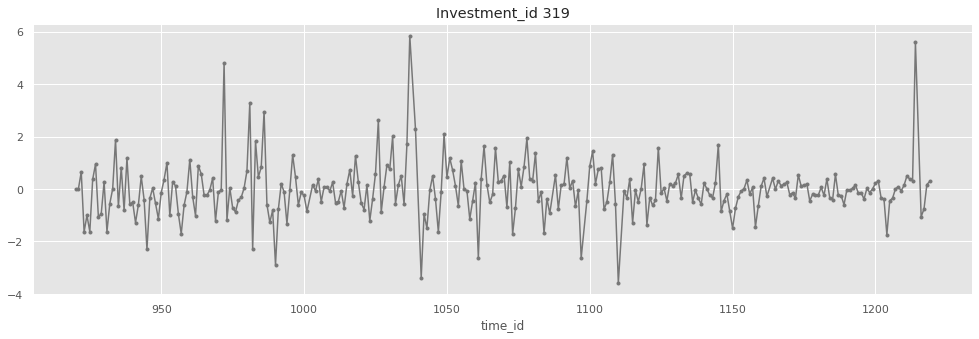

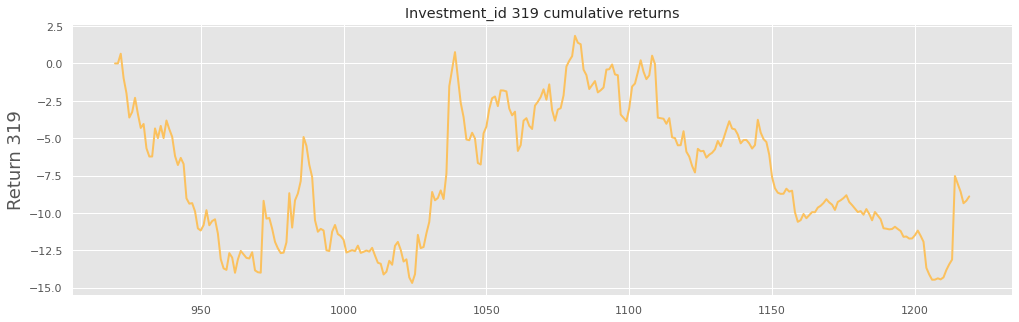

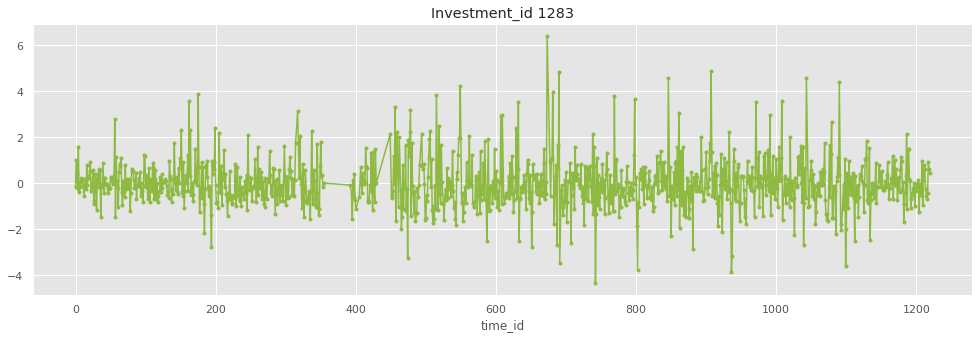

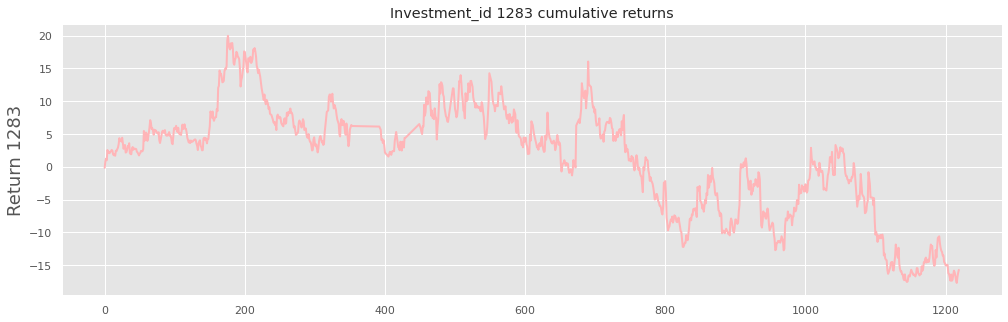

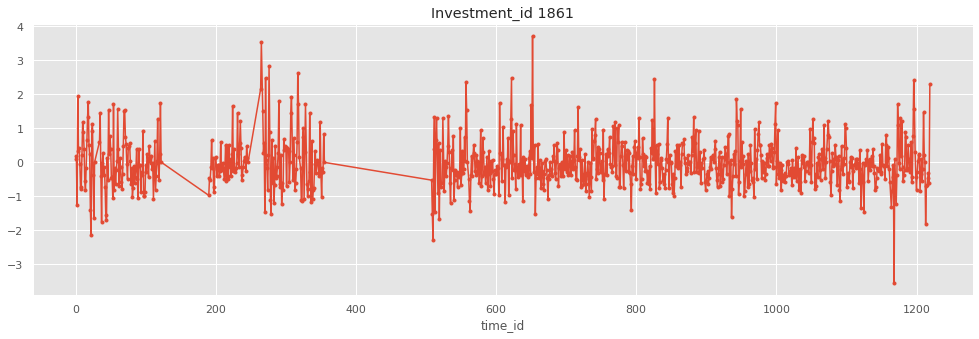

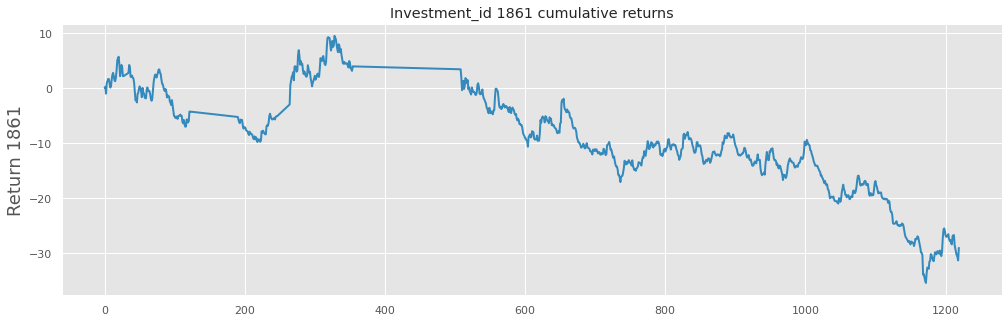

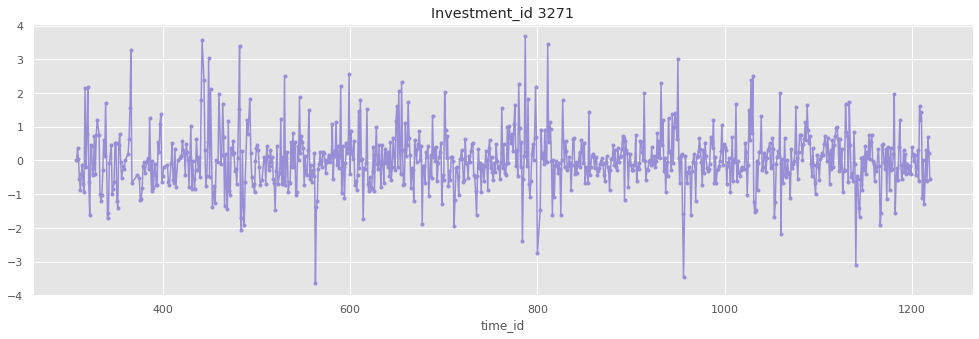

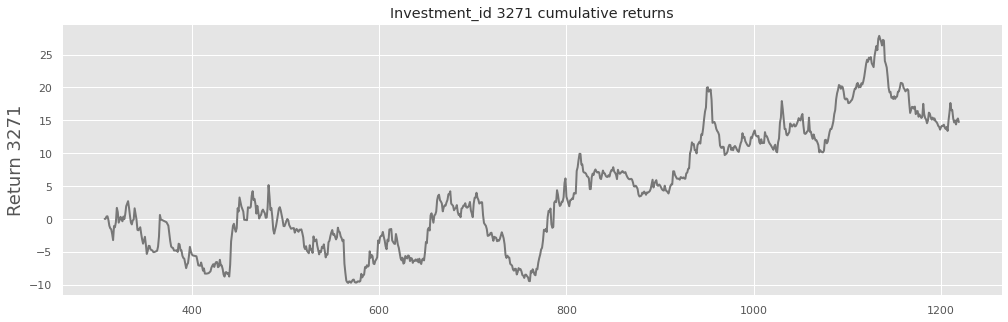

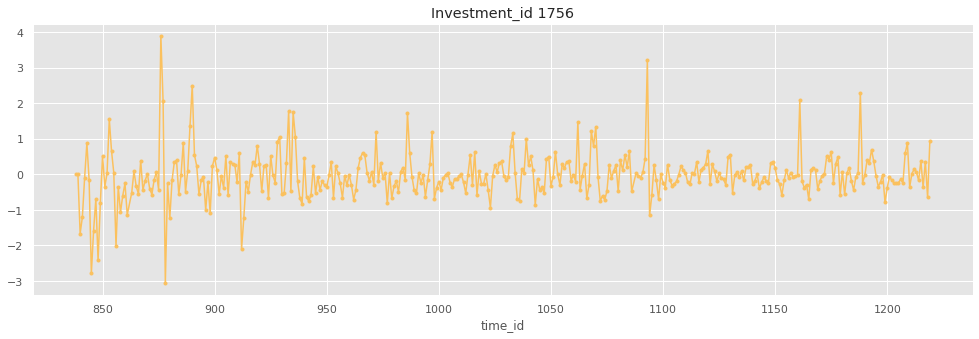

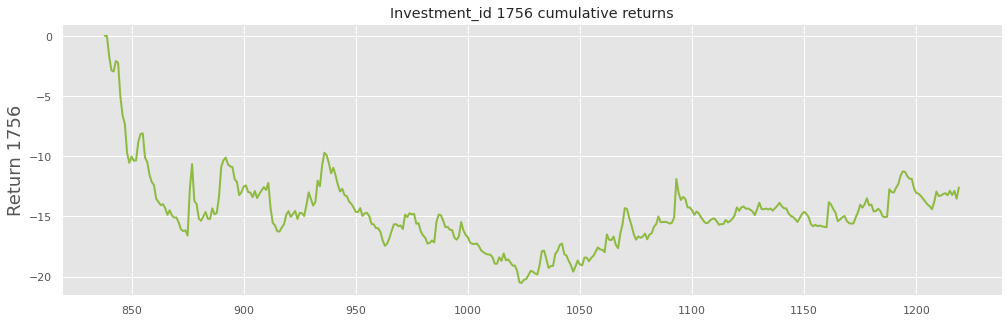

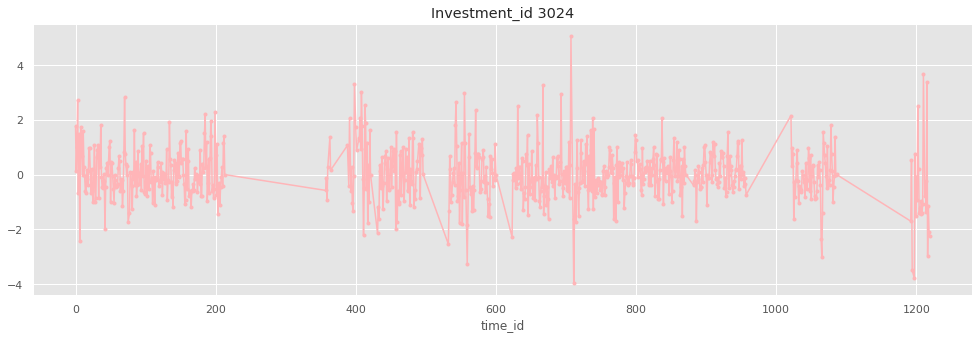

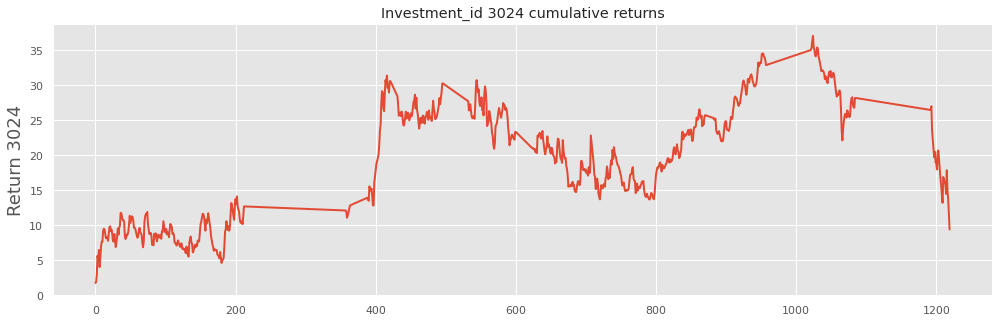

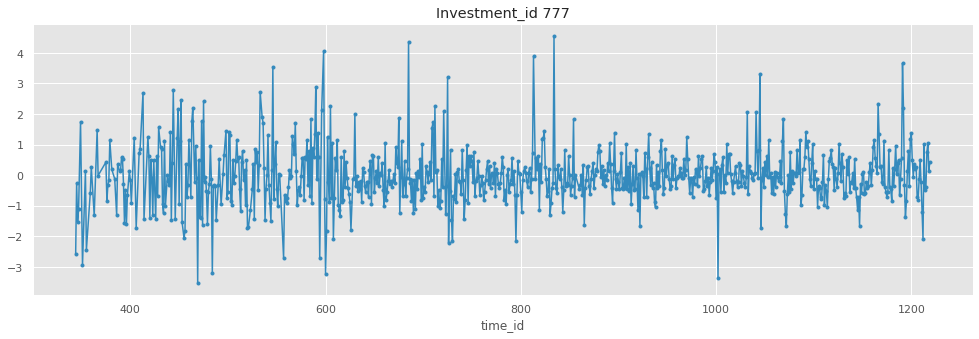

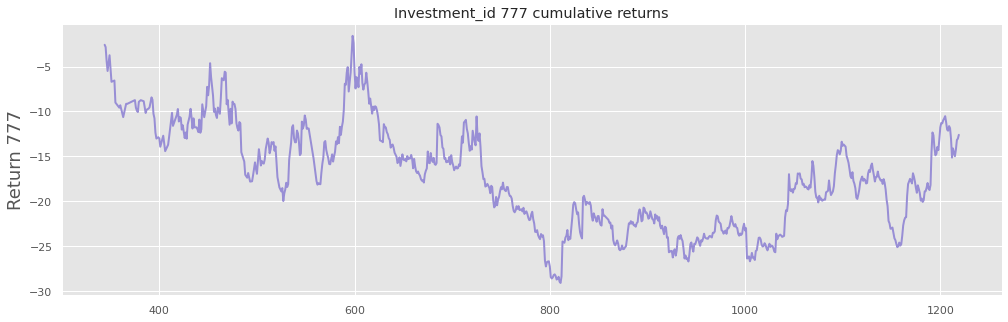

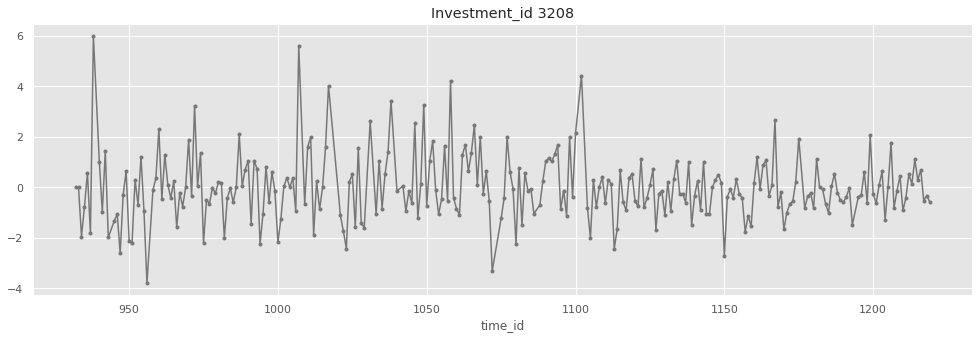

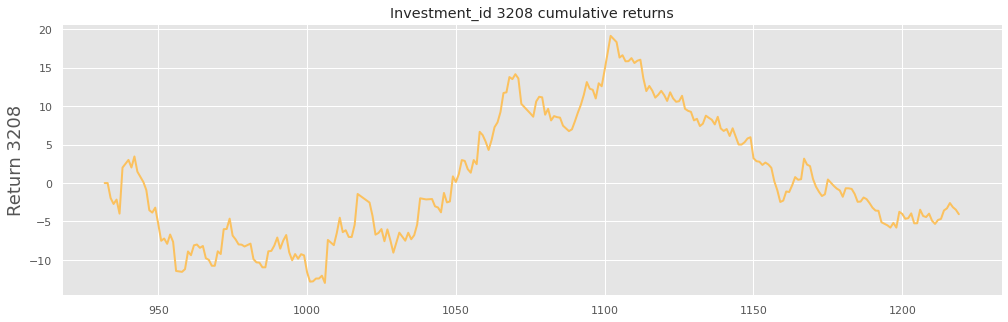

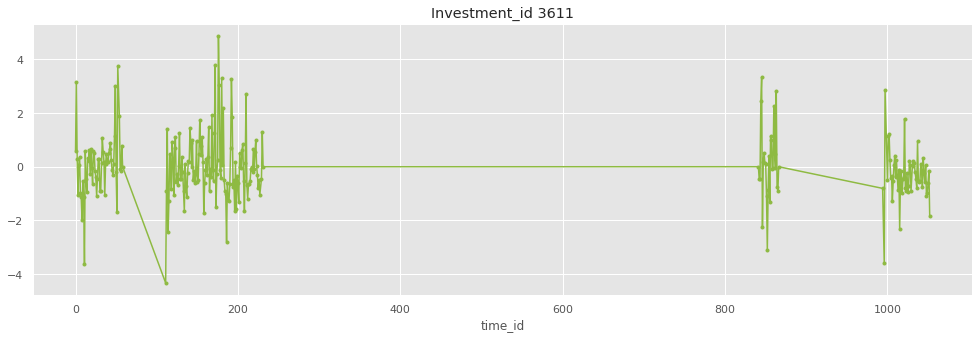

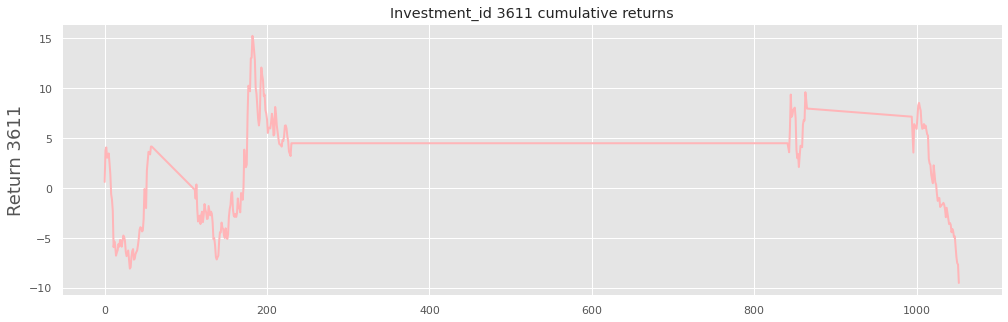

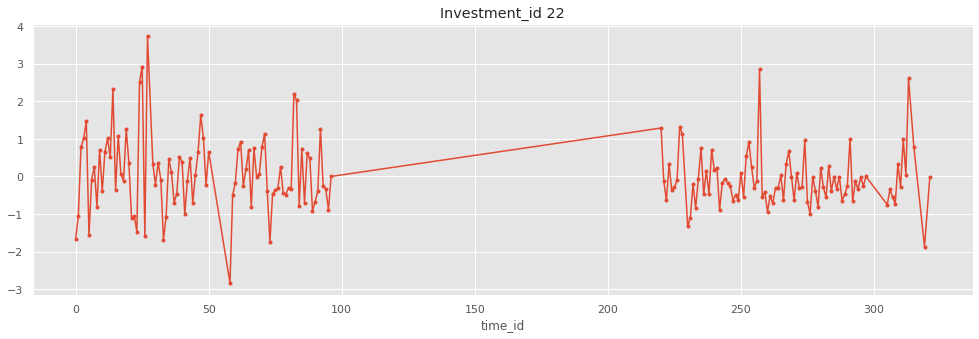

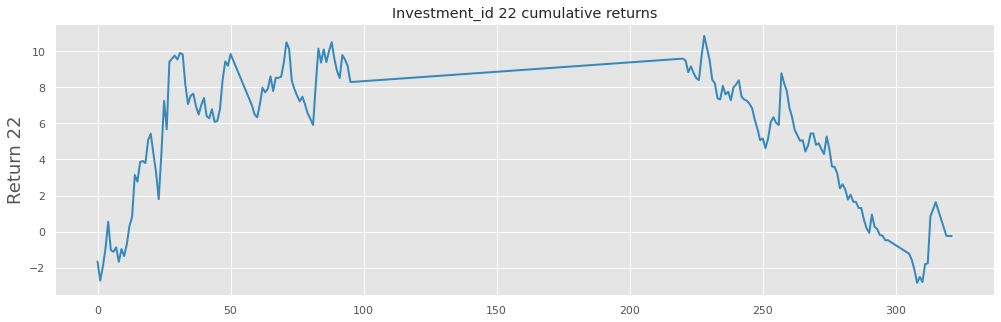

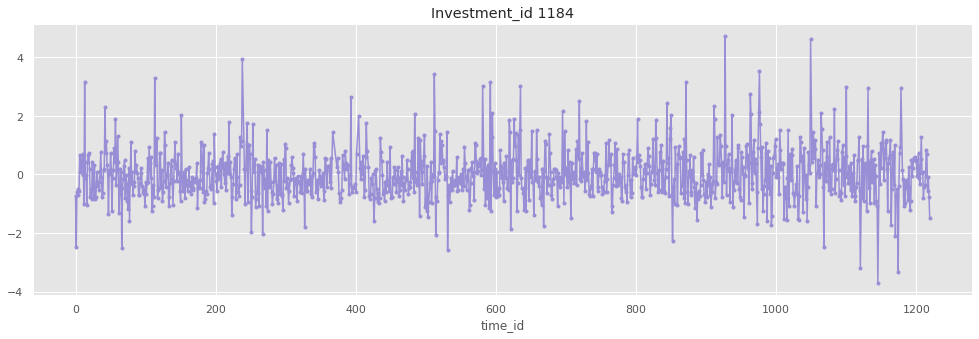

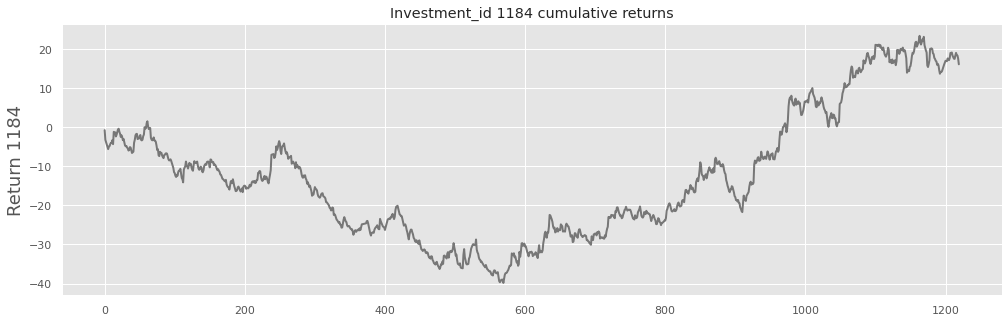

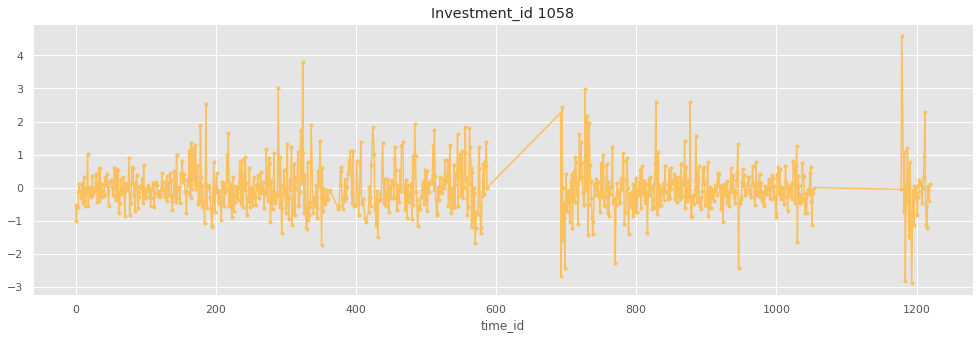

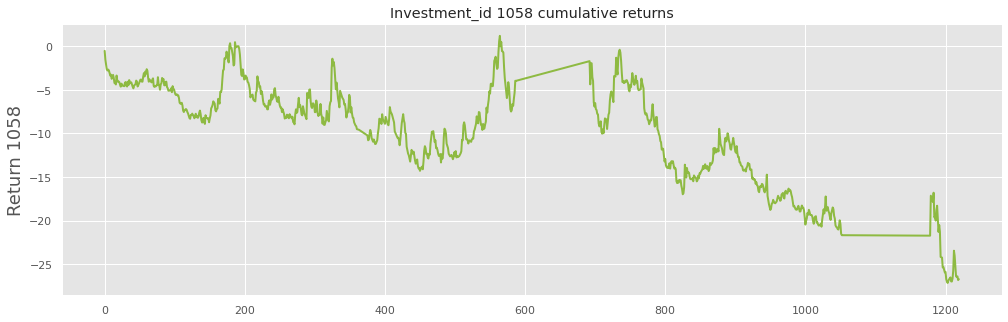

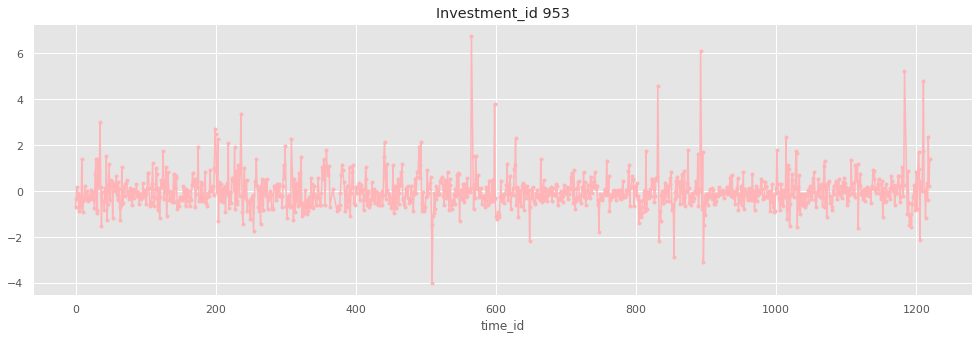

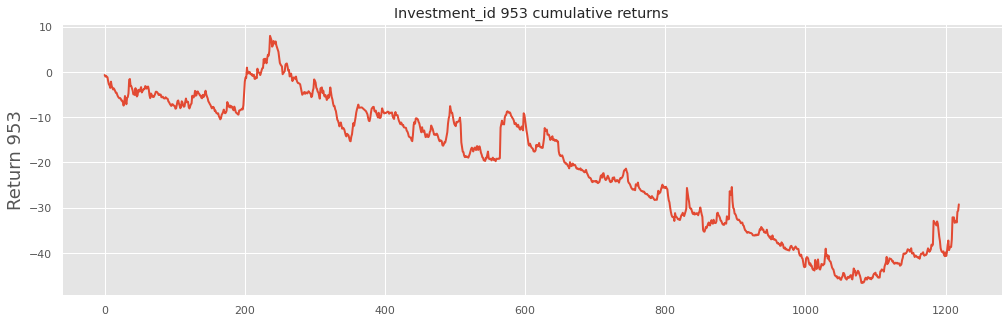

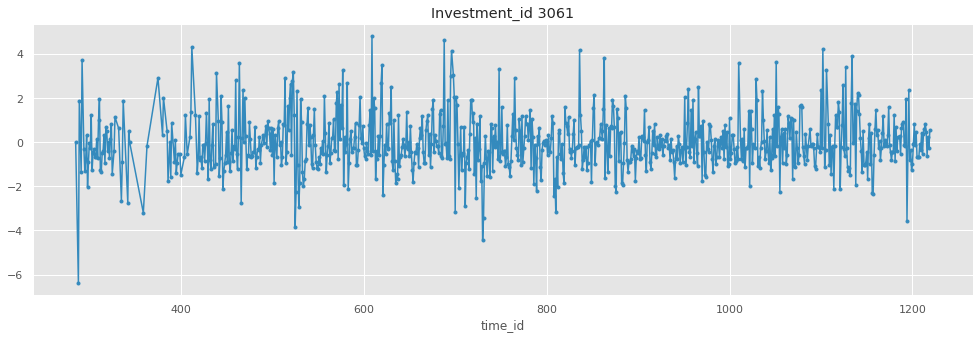

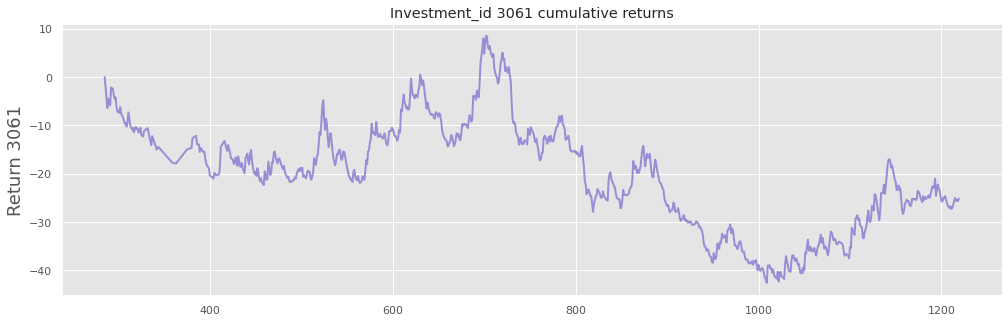

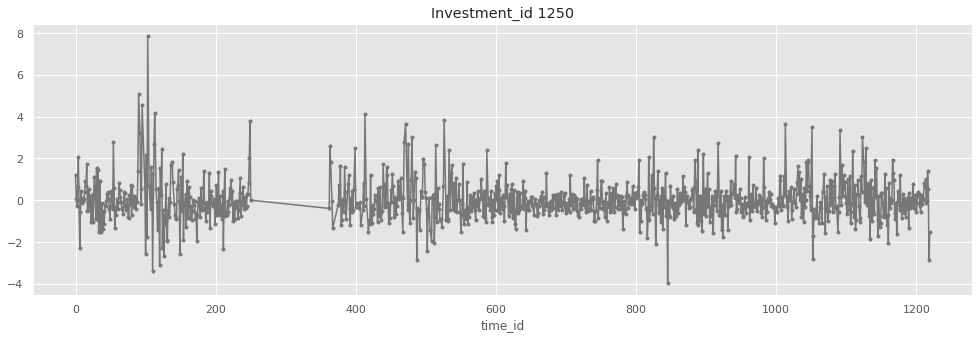

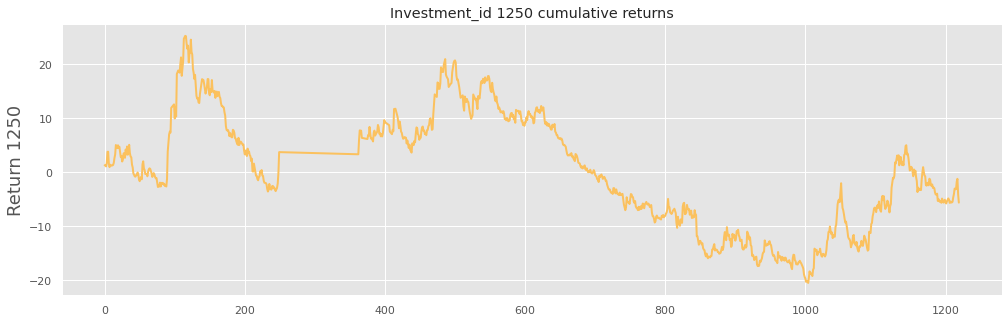

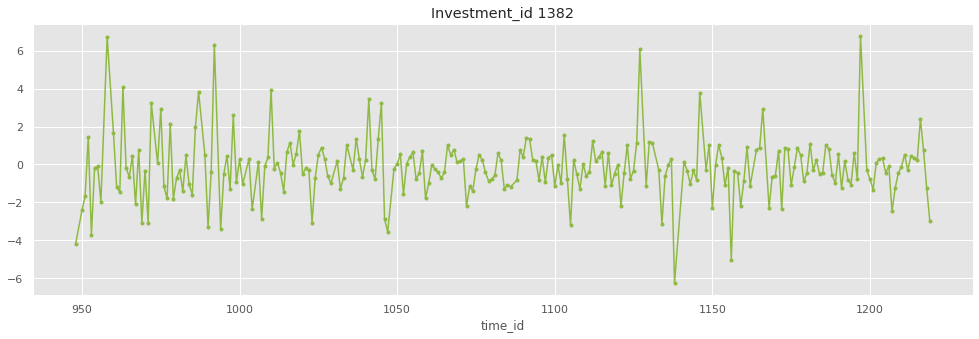

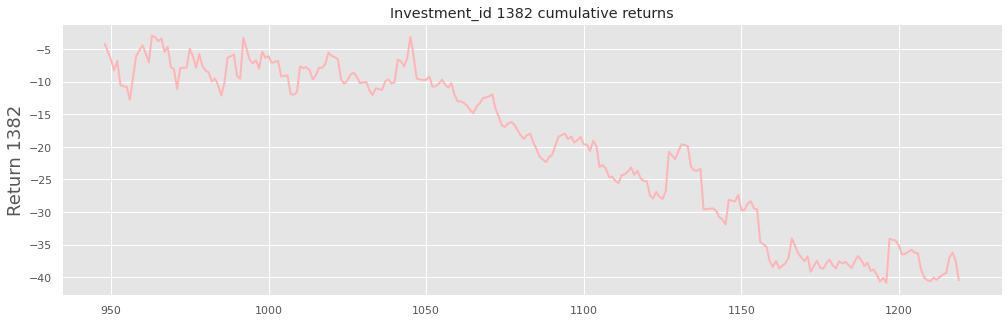

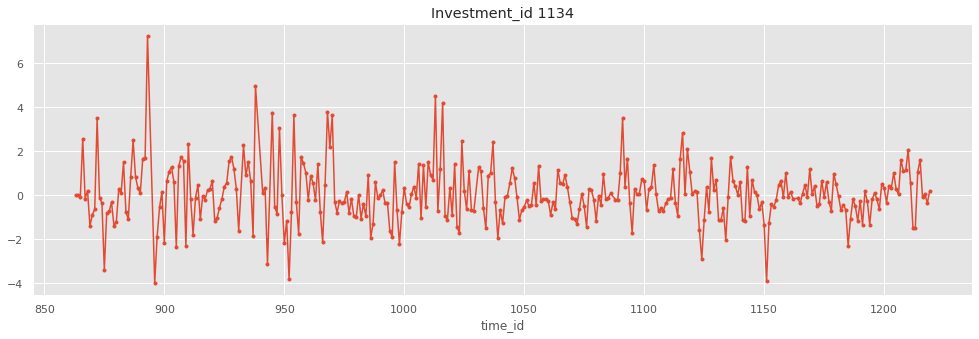

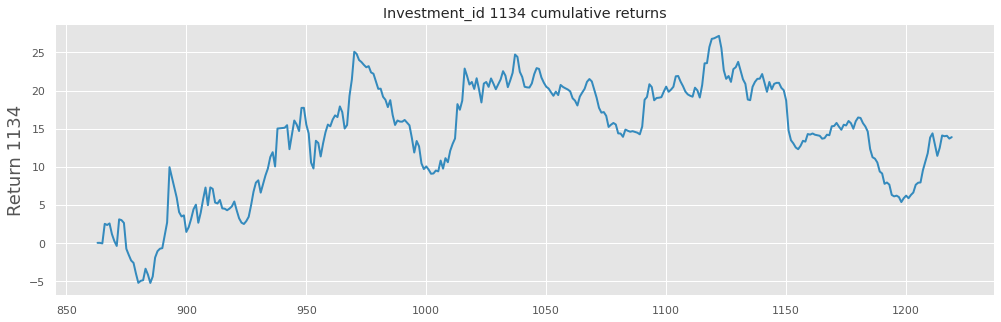

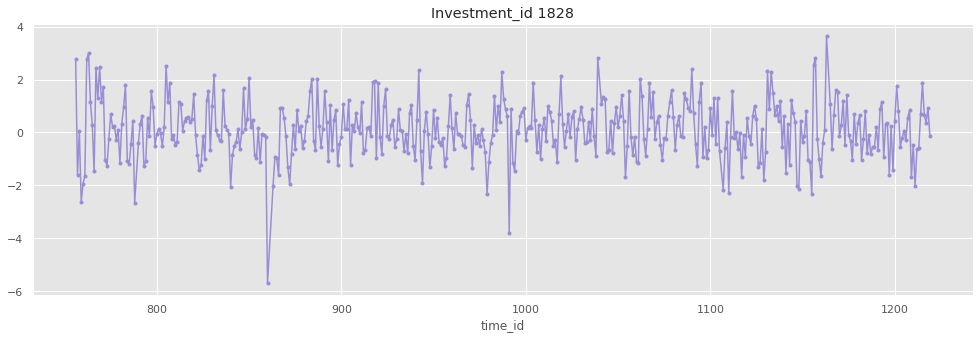

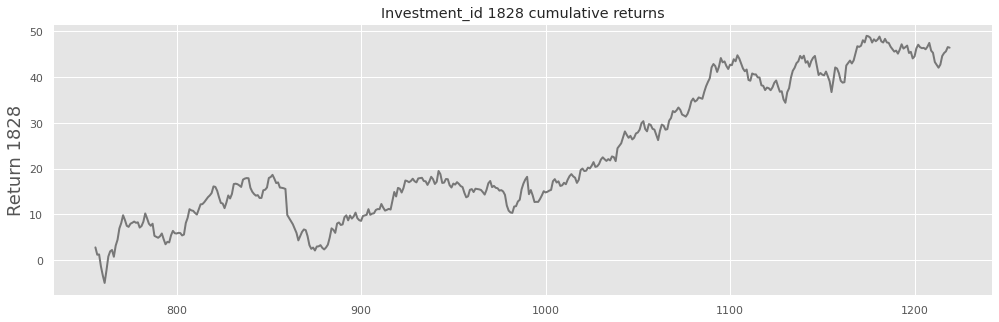

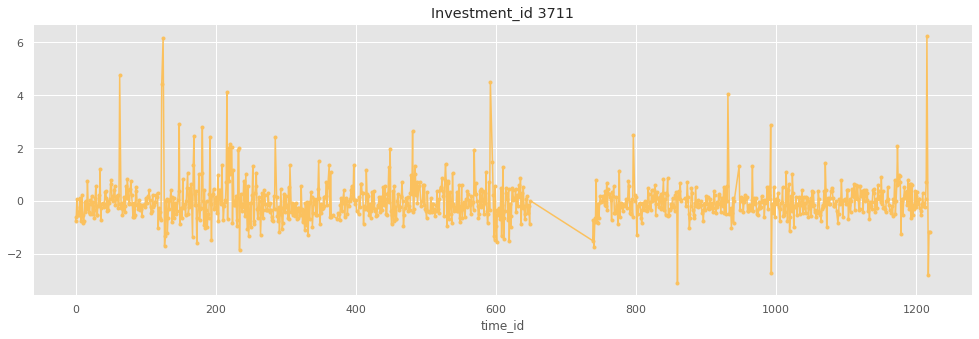

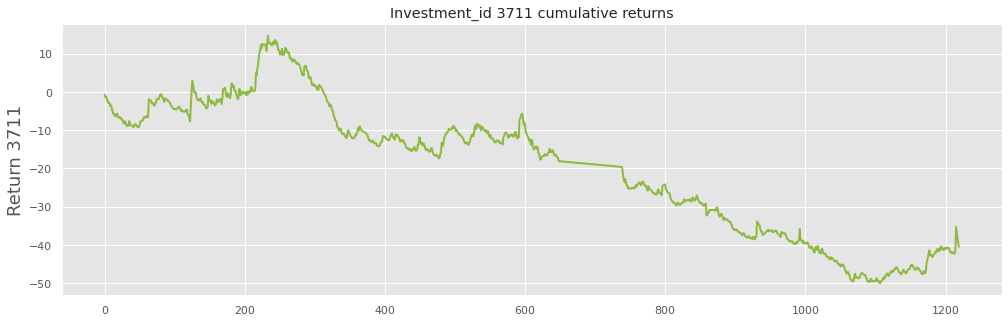

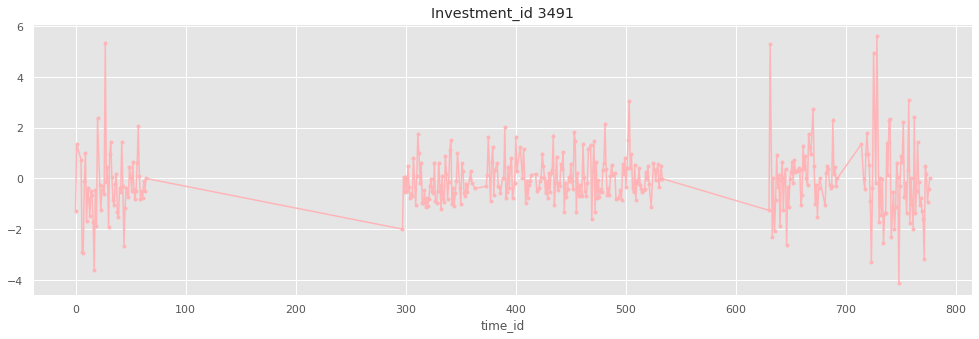

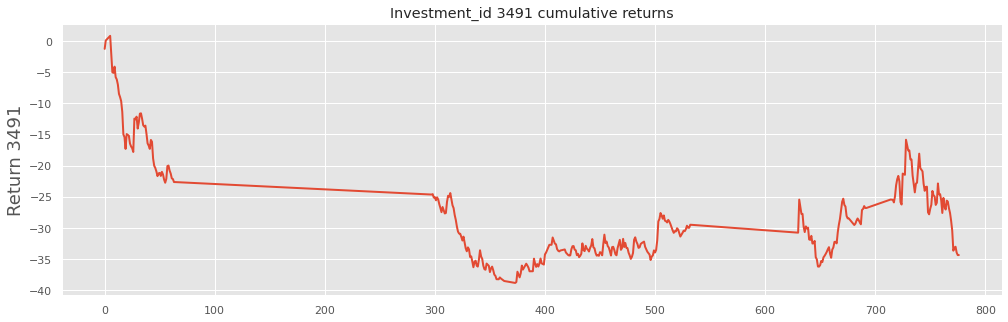

In [18]:
from itertools import cycle
plt.style.use("ggplot")
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

for investment_id in np.random.choice(train['investment_id'].unique(), 25):
    d = train.query('investment_id == @investment_id')
    d.set_index('time_id')['target'] \
        .plot(figsize=(15, 5),
              title=f'Investment_id {investment_id}',
              color=next(color_cycle),
              style='.-')
    plt.show()
    plt.figure(figsize=(15,5))
    cumReturn = train.loc[train['investment_id']==investment_id,'target'].cumsum()
    time_id = train.loc[train['investment_id']==investment_id,'time_id']
    plt.plot(time_id, cumReturn,  color=next(color_cycle), lw=2)
    plt.title(f'Investment_id {investment_id} cumulative returns')
    plt.ylabel (f'Return {investment_id}', fontsize=18)
    plt.show()

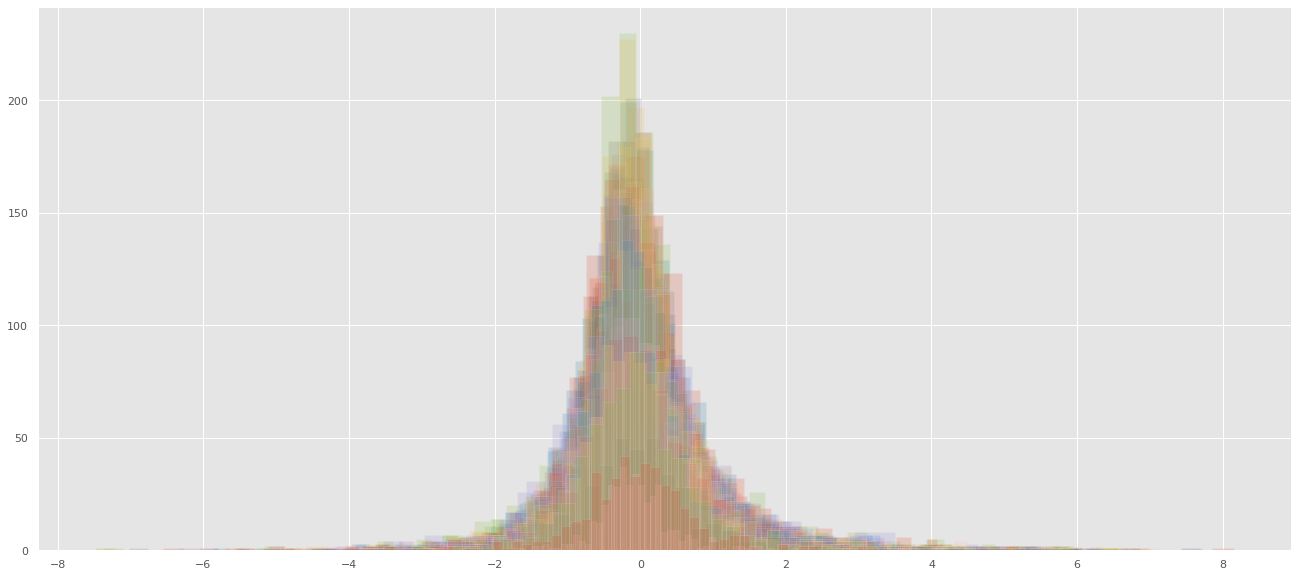

In [19]:
for f in np.random.choice(train['investment_id'].unique(), 120):
    train[train['investment_id'] == f]['target'].hist(bins = 50, alpha = 0.2, figsize = (20,10))

#  <span class="title-section w3-xxlarge" style="color:#FF0080"> 3. Basic EDA</span>

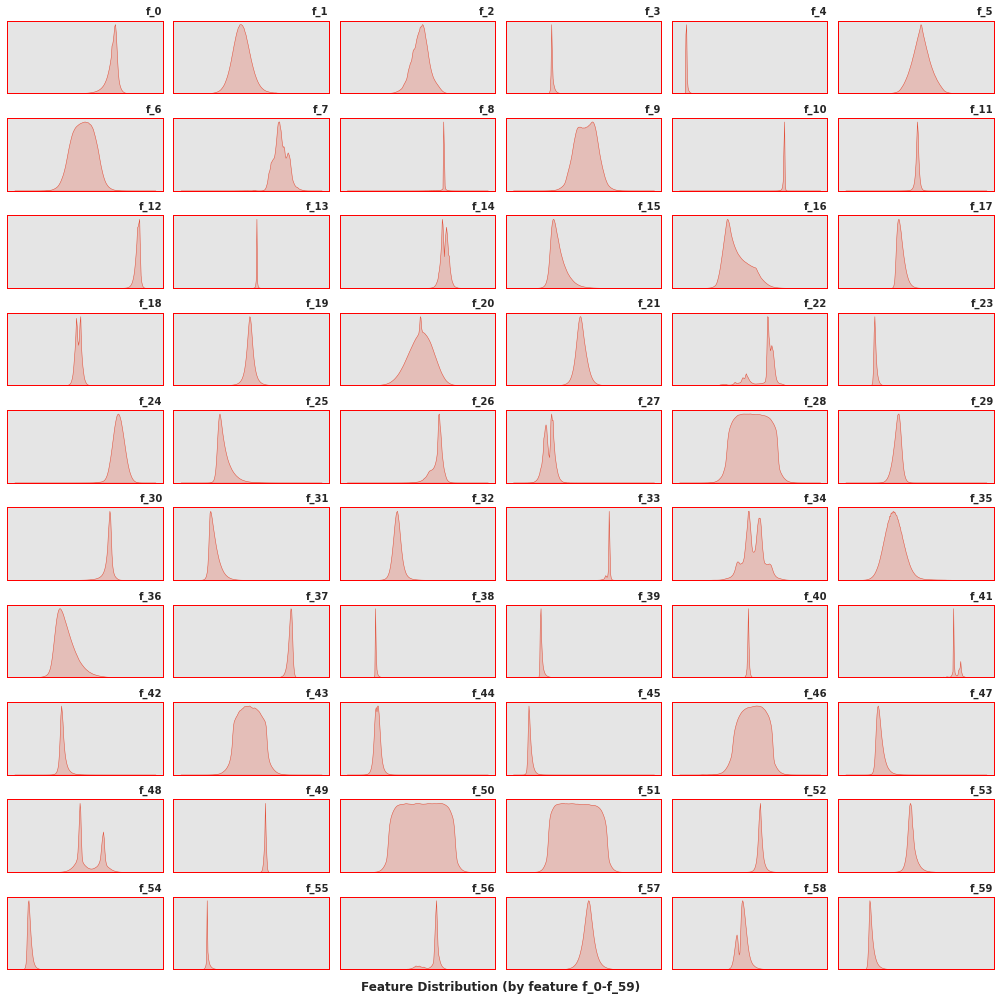

In [20]:
fig, axes = plt.subplots(10,6,figsize=(14, 14))
axes = axes.flatten()

for idx, ax in enumerate(axes):
    sns.kdeplot(data=train, x=f'f_{idx}', 
                fill=True, 
                ax=ax)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.spines['left'].set_visible(False)
    if f'f_{idx}' in train.columns:
        ax.spines[:].set_visible(True)
        ax.spines[:].set_color('red')
    ax.set_title(f'f_{idx}', loc='right', weight='bold', fontsize=10)

fig.supxlabel('Feature Distribution (by feature f_0-f_59)', ha='center', fontweight='bold')

fig.tight_layout()
plt.show()

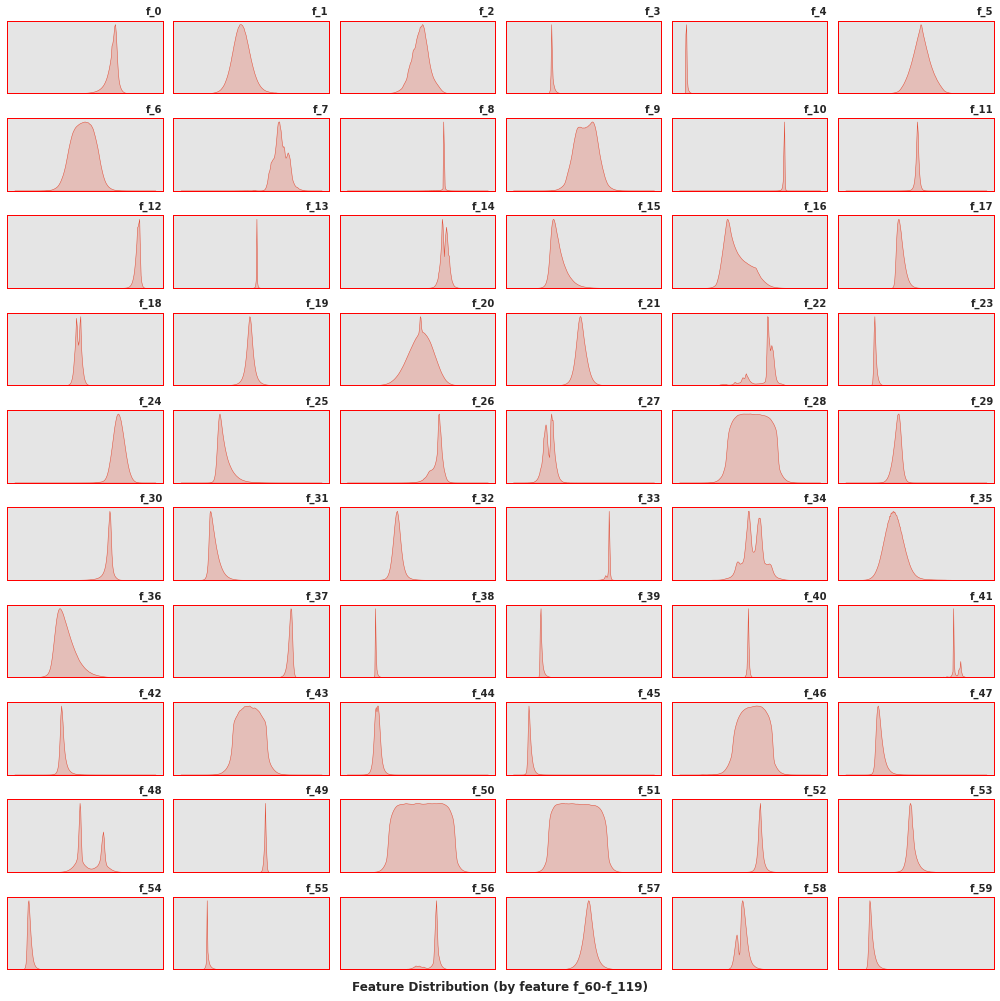

In [21]:
fig, axes = plt.subplots(10,6,figsize=(14, 14))
axes = axes.flatten()

for idx, ax in enumerate(axes):
    sns.kdeplot(data=train, x=f'f_{idx}', 
                fill=True, 
                ax=ax)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.spines['left'].set_visible(False)
    if f'f_{idx}' in train.columns:
        ax.spines[:].set_visible(True)
        ax.spines[:].set_color('red')
    ax.set_title(f'f_{idx}', loc='right', weight='bold', fontsize=10)

fig.supxlabel('Feature Distribution (by feature f_60-f_119)', ha='center', fontweight='bold')

fig.tight_layout()
plt.show()

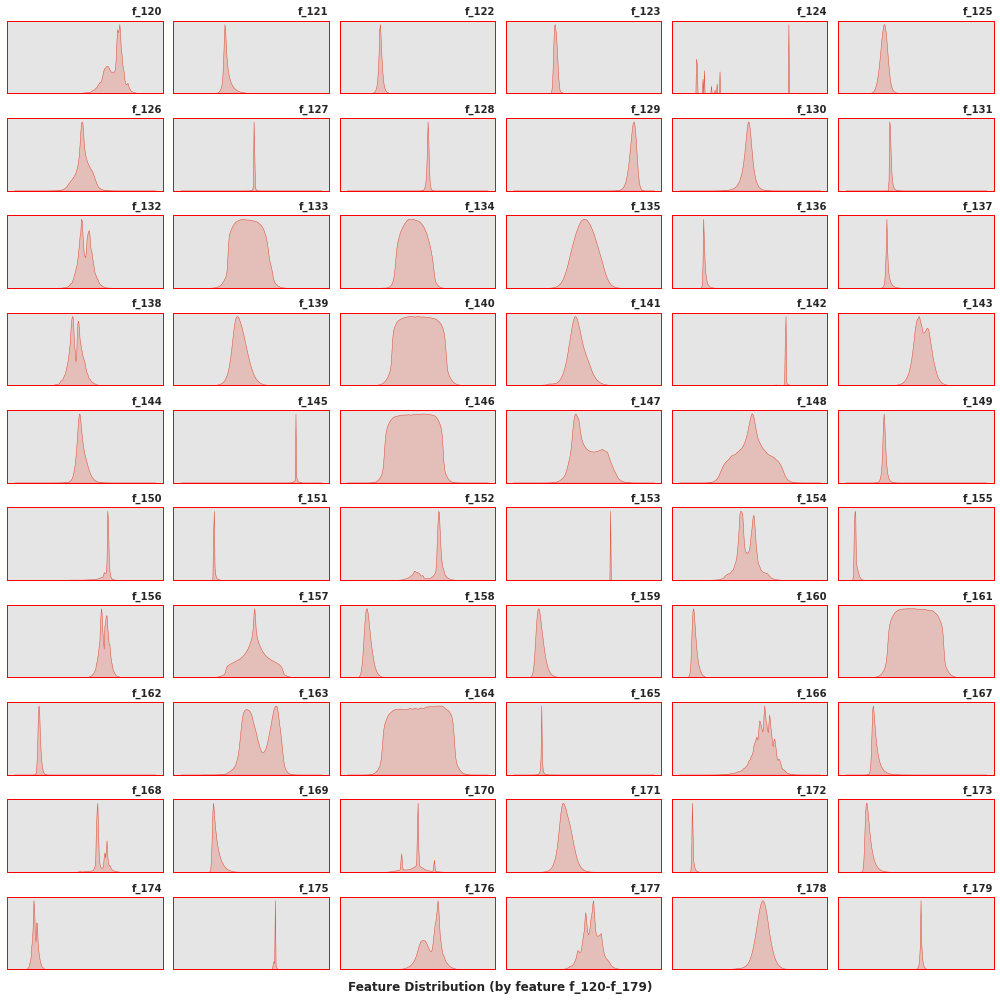

In [22]:
fig, axes = plt.subplots(10,6,figsize=(14, 14))
axes = axes.flatten()

for idx, ax in enumerate(axes, 120):
    sns.kdeplot(data=train, x=f'f_{idx}', 
                fill=True, 
                ax=ax)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.spines['left'].set_visible(False)
    if f'f_{idx}' in train.columns:
        ax.spines[:].set_visible(True)
        ax.spines[:].set_color('red')
    ax.set_title(f'f_{idx}', loc='right', weight='bold', fontsize=10)

fig.supxlabel('Feature Distribution (by feature f_120-f_179)', ha='center', fontweight='bold')

fig.tight_layout()
plt.show()

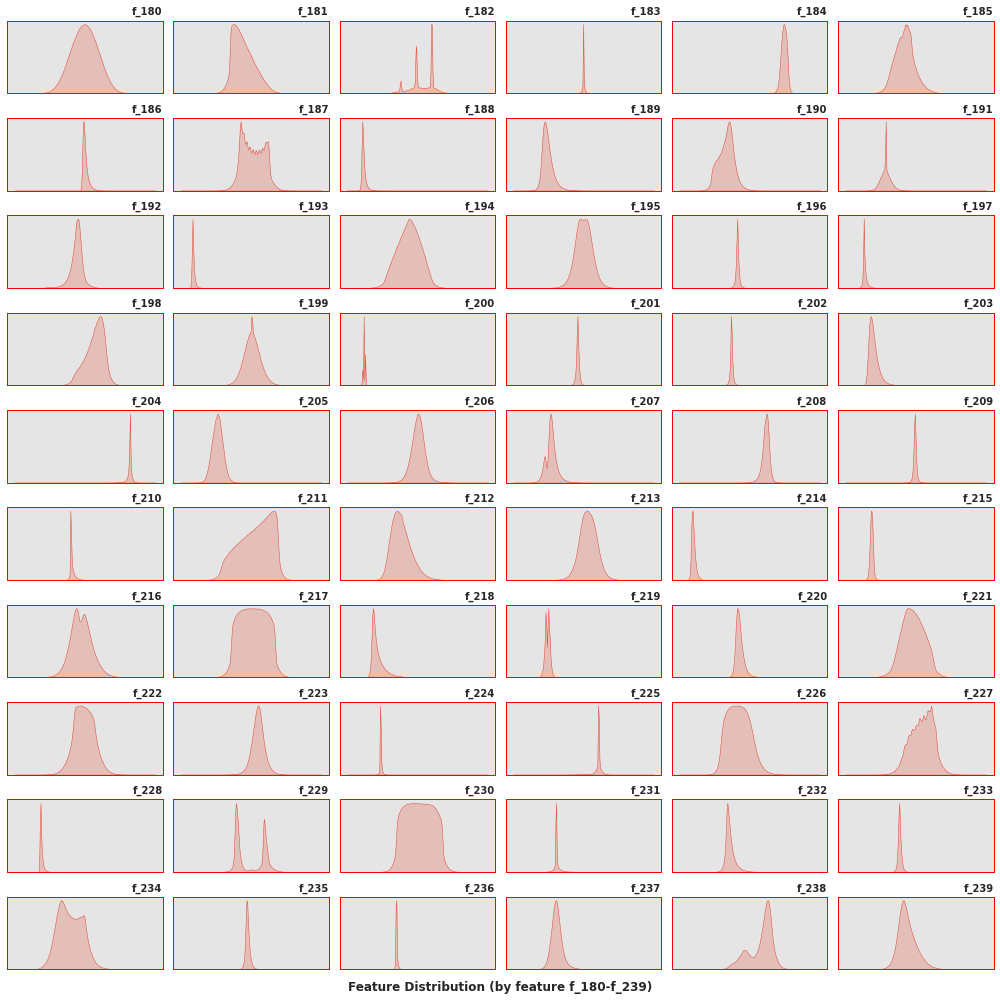

In [23]:
fig, axes = plt.subplots(10,6,figsize=(14, 14))
axes = axes.flatten()

for idx, ax in enumerate(axes, 180):
    sns.kdeplot(data=train, x=f'f_{idx}', 
                fill=True, 
                ax=ax)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.spines['left'].set_visible(False)
    if f'f_{idx}' in train.columns:
        ax.spines[:].set_visible(True)
        ax.spines[:].set_color('red')
    ax.set_title(f'f_{idx}', loc='right', weight='bold', fontsize=10)

fig.supxlabel('Feature Distribution (by feature f_180-f_239)', ha='center', fontweight='bold')

fig.tight_layout()
plt.show()

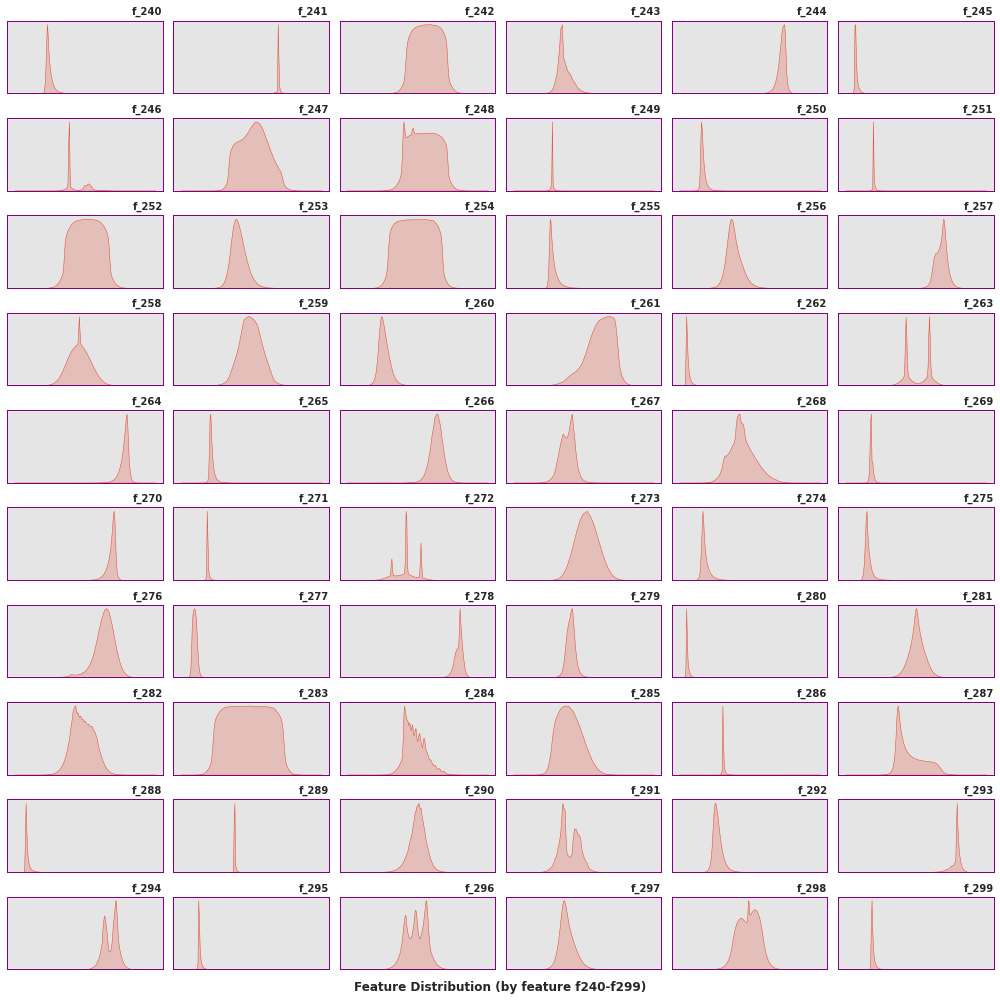

In [24]:
fig, axes = plt.subplots(10,6,figsize=(14, 14))
axes = axes.flatten()

for idx, ax in enumerate(axes, 240):
    sns.kdeplot(data=train, x=f'f_{idx}', 
                fill=True, 
                ax=ax)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.spines['left'].set_visible(False)
    if f'f_{idx}' in train.columns:
        ax.spines[:].set_visible(True)
        ax.spines[:].set_color('purple')
    ax.set_title(f'f_{idx}', loc='right', weight='bold', fontsize=10)

fig.supxlabel('Feature Distribution (by feature f240-f299)', ha='center', fontweight='bold')

fig.tight_layout()
plt.show()

##  <span class="title-section w3-xlarge" style="color:#FF0080"> Work In Progress</span>